In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : False,
    'right'         : False,
    'threshold'     : 0.6,
    'binarize'      : True,
    'not_connected' : True,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        {'sp':'normalized','im':'t1','fe':['b25'],'fi':['t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'connectivity',
    'balance_data'  : True,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : False,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'CCE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_CCE_7_1_1_0_0_1_t1t2_normalized_e_n_e_0_0_e_0_1_connectivity_data_norm_b25_t1_mask_t1_normalized_k5_b25_t1_0_42_n_normalized_08_05_06


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(4629816, 184)
(4629816, 8)
validation
(621056, 184)
(621056, 8)
test
(624904, 184)
(624904, 8)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 184)]             0         


 dense (Dense)               (None, 1024)              189440    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 8)                 1032      


Total params: 879496 (3.36 MB)


Trainable params: 879496 (3.36 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


  1/463 [..............................] - ETA: 12:38 - loss: 2.4624 - STD: 0.0837 - MAE: 0.2206

  5/463 [..............................] - ETA: 6s - loss: 2.1869 - STD: 0.0469 - MAE: 0.2186   

  9/463 [..............................] - ETA: 6s - loss: 2.1503 - STD: 0.0603 - MAE: 0.2165

 13/463 [..............................] - ETA: 5s - loss: 2.1270 - STD: 0.0561 - MAE: 0.2164

 18/463 [>.............................] - ETA: 5s - loss: 2.1078 - STD: 0.0472 - MAE: 0.2167

 23/463 [>.............................] - ETA: 5s - loss: 2.0979 - STD: 0.0433 - MAE: 0.2168

 27/463 [>.............................] - ETA: 5s - loss: 2.0912 - STD: 0.0418 - MAE: 0.2168

 31/463 [=>............................] - ETA: 5s - loss: 2.0861 - STD: 0.0411 - MAE: 0.2167

 35/463 [=>............................] - ETA: 5s - loss: 2.0825 - STD: 0.0408 - MAE: 0.2167

 39/463 [=>............................] - ETA: 5s - loss: 2.0792 - STD: 0.0401 - MAE: 0.2167

 43/463 [=>............................] - ETA: 5s - loss: 2.0768 - STD: 0.0392 - MAE: 0.2167

 47/463 [==>...........................] - ETA: 5s - loss: 2.0747 - STD: 0.0383 - MAE: 0.2167

 52/463 [==>...........................] - ETA: 5s - loss: 2.0725 - STD: 0.0376 - MAE: 0.2167

 56/463 [==>...........................] - ETA: 5s - loss: 2.0708 - STD: 0.0373 - MAE: 0.2167

 60/463 [==>...........................] - ETA: 5s - loss: 2.0695 - STD: 0.0372 - MAE: 0.2167

 64/463 [===>..........................] - ETA: 5s - loss: 2.0684 - STD: 0.0369 - MAE: 0.2167

 68/463 [===>..........................] - ETA: 5s - loss: 2.0672 - STD: 0.0365 - MAE: 0.2167

 72/463 [===>..........................] - ETA: 5s - loss: 2.0663 - STD: 0.0363 - MAE: 0.2167

 76/463 [===>..........................] - ETA: 4s - loss: 2.0654 - STD: 0.0362 - MAE: 0.2167

 80/463 [====>.........................] - ETA: 4s - loss: 2.0646 - STD: 0.0359 - MAE: 0.2167

 84/463 [====>.........................] - ETA: 4s - loss: 2.0639 - STD: 0.0357 - MAE: 0.2167

 88/463 [====>.........................] - ETA: 4s - loss: 2.0631 - STD: 0.0355 - MAE: 0.2167

 92/463 [====>.........................] - ETA: 4s - loss: 2.0624 - STD: 0.0353 - MAE: 0.2167

 96/463 [=====>........................] - ETA: 4s - loss: 2.0616 - STD: 0.0352 - MAE: 0.2167

100/463 [=====>........................] - ETA: 4s - loss: 2.0606 - STD: 0.0351 - MAE: 0.2167

104/463 [=====>........................] - ETA: 4s - loss: 2.0592 - STD: 0.0350 - MAE: 0.2166

108/463 [=====>........................] - ETA: 4s - loss: 2.0576 - STD: 0.0350 - MAE: 0.2166

112/463 [======>.......................] - ETA: 4s - loss: 2.0555 - STD: 0.0351 - MAE: 0.2165

116/463 [======>.......................] - ETA: 4s - loss: 2.0531 - STD: 0.0353 - MAE: 0.2164

121/463 [======>.......................] - ETA: 4s - loss: 2.0496 - STD: 0.0358 - MAE: 0.2163

125/463 [=======>......................] - ETA: 4s - loss: 2.0465 - STD: 0.0364 - MAE: 0.2162

129/463 [=======>......................] - ETA: 4s - loss: 2.0434 - STD: 0.0372 - MAE: 0.2160

133/463 [=======>......................] - ETA: 4s - loss: 2.0404 - STD: 0.0379 - MAE: 0.2159

137/463 [=======>......................] - ETA: 4s - loss: 2.0375 - STD: 0.0386 - MAE: 0.2157

141/463 [========>.....................] - ETA: 4s - loss: 2.0346 - STD: 0.0394 - MAE: 0.2156

146/463 [========>.....................] - ETA: 4s - loss: 2.0311 - STD: 0.0402 - MAE: 0.2154

150/463 [========>.....................] - ETA: 4s - loss: 2.0285 - STD: 0.0408 - MAE: 0.2153

154/463 [========>.....................] - ETA: 3s - loss: 2.0260 - STD: 0.0414 - MAE: 0.2152

158/463 [=========>....................] - ETA: 3s - loss: 2.0235 - STD: 0.0420 - MAE: 0.2150

163/463 [=========>....................] - ETA: 3s - loss: 2.0204 - STD: 0.0428 - MAE: 0.2149

165/463 [=========>....................] - ETA: 5s - loss: 2.0192 - STD: 0.0430 - MAE: 0.2148

169/463 [=========>....................] - ETA: 5s - loss: 2.0168 - STD: 0.0436 - MAE: 0.2147

173/463 [==========>...................] - ETA: 5s - loss: 2.0144 - STD: 0.0441 - MAE: 0.2146

178/463 [==========>...................] - ETA: 5s - loss: 2.0115 - STD: 0.0447 - MAE: 0.2144

182/463 [==========>...................] - ETA: 5s - loss: 2.0093 - STD: 0.0452 - MAE: 0.2143

186/463 [===========>..................] - ETA: 5s - loss: 2.0072 - STD: 0.0457 - MAE: 0.2142

190/463 [===========>..................] - ETA: 5s - loss: 2.0052 - STD: 0.0462 - MAE: 0.2141

194/463 [===========>..................] - ETA: 4s - loss: 2.0031 - STD: 0.0466 - MAE: 0.2140

198/463 [===========>..................] - ETA: 4s - loss: 2.0010 - STD: 0.0471 - MAE: 0.2139

202/463 [============>.................] - ETA: 4s - loss: 1.9990 - STD: 0.0475 - MAE: 0.2138

206/463 [============>.................] - ETA: 4s - loss: 1.9969 - STD: 0.0479 - MAE: 0.2137

210/463 [============>.................] - ETA: 4s - loss: 1.9948 - STD: 0.0484 - MAE: 0.2136

214/463 [============>.................] - ETA: 4s - loss: 1.9927 - STD: 0.0488 - MAE: 0.2135

218/463 [=============>................] - ETA: 4s - loss: 1.9908 - STD: 0.0493 - MAE: 0.2134

222/463 [=============>................] - ETA: 4s - loss: 1.9887 - STD: 0.0497 - MAE: 0.2133

226/463 [=============>................] - ETA: 4s - loss: 1.9868 - STD: 0.0501 - MAE: 0.2132

230/463 [=============>................] - ETA: 4s - loss: 1.9847 - STD: 0.0505 - MAE: 0.2130

235/463 [==============>...............] - ETA: 3s - loss: 1.9822 - STD: 0.0511 - MAE: 0.2129

239/463 [==============>...............] - ETA: 3s - loss: 1.9800 - STD: 0.0515 - MAE: 0.2128

243/463 [==============>...............] - ETA: 3s - loss: 1.9778 - STD: 0.0520 - MAE: 0.2126

248/463 [===============>..............] - ETA: 3s - loss: 1.9751 - STD: 0.0525 - MAE: 0.2125

252/463 [===============>..............] - ETA: 3s - loss: 1.9727 - STD: 0.0530 - MAE: 0.2124

256/463 [===============>..............] - ETA: 3s - loss: 1.9703 - STD: 0.0535 - MAE: 0.2122

260/463 [===============>..............] - ETA: 3s - loss: 1.9678 - STD: 0.0540 - MAE: 0.2121

264/463 [================>.............] - ETA: 3s - loss: 1.9653 - STD: 0.0545 - MAE: 0.2119

269/463 [================>.............] - ETA: 3s - loss: 1.9621 - STD: 0.0552 - MAE: 0.2117

274/463 [================>.............] - ETA: 3s - loss: 1.9590 - STD: 0.0559 - MAE: 0.2115

279/463 [=================>............] - ETA: 3s - loss: 1.9560 - STD: 0.0566 - MAE: 0.2113

284/463 [=================>............] - ETA: 2s - loss: 1.9531 - STD: 0.0573 - MAE: 0.2111

289/463 [=================>............] - ETA: 2s - loss: 1.9500 - STD: 0.0579 - MAE: 0.2109

294/463 [==================>...........] - ETA: 2s - loss: 1.9470 - STD: 0.0586 - MAE: 0.2107

299/463 [==================>...........] - ETA: 2s - loss: 1.9440 - STD: 0.0592 - MAE: 0.2105

304/463 [==================>...........] - ETA: 2s - loss: 1.9410 - STD: 0.0599 - MAE: 0.2103

309/463 [===================>..........] - ETA: 2s - loss: 1.9381 - STD: 0.0605 - MAE: 0.2101

314/463 [===================>..........] - ETA: 2s - loss: 1.9352 - STD: 0.0611 - MAE: 0.2099

319/463 [===================>..........] - ETA: 2s - loss: 1.9324 - STD: 0.0618 - MAE: 0.2098

324/463 [===================>..........] - ETA: 2s - loss: 1.9296 - STD: 0.0624 - MAE: 0.2096

328/463 [====================>.........] - ETA: 2s - loss: 1.9275 - STD: 0.0628 - MAE: 0.2094

333/463 [====================>.........] - ETA: 2s - loss: 1.9248 - STD: 0.0634 - MAE: 0.2092

337/463 [====================>.........] - ETA: 2s - loss: 1.9226 - STD: 0.0639 - MAE: 0.2091

341/463 [=====================>........] - ETA: 1s - loss: 1.9203 - STD: 0.0643 - MAE: 0.2089

345/463 [=====================>........] - ETA: 1s - loss: 1.9182 - STD: 0.0648 - MAE: 0.2088

349/463 [=====================>........] - ETA: 1s - loss: 1.9161 - STD: 0.0652 - MAE: 0.2087

353/463 [=====================>........] - ETA: 1s - loss: 1.9141 - STD: 0.0657 - MAE: 0.2085

357/463 [======================>.......] - ETA: 1s - loss: 1.9121 - STD: 0.0661 - MAE: 0.2084

362/463 [======================>.......] - ETA: 1s - loss: 1.9095 - STD: 0.0666 - MAE: 0.2082

367/463 [======================>.......] - ETA: 1s - loss: 1.9071 - STD: 0.0671 - MAE: 0.2081

372/463 [=======================>......] - ETA: 1s - loss: 1.9048 - STD: 0.0676 - MAE: 0.2079

376/463 [=======================>......] - ETA: 1s - loss: 1.9029 - STD: 0.0680 - MAE: 0.2078

381/463 [=======================>......] - ETA: 1s - loss: 1.9006 - STD: 0.0685 - MAE: 0.2076

386/463 [========================>.....] - ETA: 1s - loss: 1.8982 - STD: 0.0690 - MAE: 0.2075

390/463 [========================>.....] - ETA: 1s - loss: 1.8963 - STD: 0.0694 - MAE: 0.2073

394/463 [========================>.....] - ETA: 1s - loss: 1.8945 - STD: 0.0697 - MAE: 0.2072

398/463 [========================>.....] - ETA: 1s - loss: 1.8927 - STD: 0.0701 - MAE: 0.2071

403/463 [=========================>....] - ETA: 0s - loss: 1.8904 - STD: 0.0706 - MAE: 0.2070

407/463 [=========================>....] - ETA: 0s - loss: 1.8886 - STD: 0.0710 - MAE: 0.2068

412/463 [=========================>....] - ETA: 0s - loss: 1.8865 - STD: 0.0714 - MAE: 0.2067

416/463 [=========================>....] - ETA: 0s - loss: 1.8848 - STD: 0.0718 - MAE: 0.2066

421/463 [==========================>...] - ETA: 0s - loss: 1.8828 - STD: 0.0723 - MAE: 0.2064

425/463 [==========================>...] - ETA: 0s - loss: 1.8812 - STD: 0.0726 - MAE: 0.2063

429/463 [==========================>...] - ETA: 0s - loss: 1.8796 - STD: 0.0730 - MAE: 0.2062

433/463 [===========================>..] - ETA: 0s - loss: 1.8780 - STD: 0.0733 - MAE: 0.2061

437/463 [===========================>..] - ETA: 0s - loss: 1.8764 - STD: 0.0736 - MAE: 0.2060

441/463 [===========================>..] - ETA: 0s - loss: 1.8747 - STD: 0.0739 - MAE: 0.2059

445/463 [===========================>..] - ETA: 0s - loss: 1.8731 - STD: 0.0743 - MAE: 0.2058

449/463 [============================>.] - ETA: 0s - loss: 1.8715 - STD: 0.0746 - MAE: 0.2057

453/463 [============================>.] - ETA: 0s - loss: 1.8699 - STD: 0.0749 - MAE: 0.2055

457/463 [============================>.] - ETA: 0s - loss: 1.8684 - STD: 0.0752 - MAE: 0.2054

461/463 [============================>.] - ETA: 0s - loss: 1.8669 - STD: 0.0755 - MAE: 0.2053

463/463 [==============================] - 10s 17ms/step - loss: 1.8661 - STD: 0.0757 - MAE: 0.2053 - val_loss: 1.7315 - val_STD: 0.1059 - val_MAE: 0.1956


Epoch 2/10000


  1/463 [..............................] - ETA: 15s - loss: 1.6905 - STD: 0.1103 - MAE: 0.1934

  5/463 [..............................] - ETA: 5s - loss: 1.6912 - STD: 0.1101 - MAE: 0.1936 

  9/463 [..............................] - ETA: 5s - loss: 1.6916 - STD: 0.1113 - MAE: 0.1934

 13/463 [..............................] - ETA: 6s - loss: 1.6907 - STD: 0.1111 - MAE: 0.1934

 17/463 [>.............................] - ETA: 5s - loss: 1.6884 - STD: 0.1118 - MAE: 0.1932

 21/463 [>.............................] - ETA: 5s - loss: 1.6889 - STD: 0.1115 - MAE: 0.1932

 25/463 [>.............................] - ETA: 5s - loss: 1.6879 - STD: 0.1119 - MAE: 0.1931

 29/463 [>.............................] - ETA: 5s - loss: 1.6876 - STD: 0.1119 - MAE: 0.1931

 33/463 [=>............................] - ETA: 5s - loss: 1.6871 - STD: 0.1121 - MAE: 0.1930

 37/463 [=>............................] - ETA: 5s - loss: 1.6866 - STD: 0.1122 - MAE: 0.1930

 41/463 [=>............................] - ETA: 5s - loss: 1.6865 - STD: 0.1123 - MAE: 0.1930

 45/463 [=>............................] - ETA: 5s - loss: 1.6859 - STD: 0.1126 - MAE: 0.1929

 49/463 [==>...........................] - ETA: 5s - loss: 1.6855 - STD: 0.1126 - MAE: 0.1929

 54/463 [==>...........................] - ETA: 5s - loss: 1.6844 - STD: 0.1128 - MAE: 0.1928

 58/463 [==>...........................] - ETA: 5s - loss: 1.6845 - STD: 0.1128 - MAE: 0.1928

 63/463 [===>..........................] - ETA: 5s - loss: 1.6834 - STD: 0.1129 - MAE: 0.1927

 68/463 [===>..........................] - ETA: 5s - loss: 1.6830 - STD: 0.1131 - MAE: 0.1927

 72/463 [===>..........................] - ETA: 4s - loss: 1.6825 - STD: 0.1131 - MAE: 0.1927

 76/463 [===>..........................] - ETA: 4s - loss: 1.6823 - STD: 0.1132 - MAE: 0.1926

 81/463 [====>.........................] - ETA: 4s - loss: 1.6817 - STD: 0.1132 - MAE: 0.1926

 85/463 [====>.........................] - ETA: 4s - loss: 1.6809 - STD: 0.1134 - MAE: 0.1925

 90/463 [====>.........................] - ETA: 4s - loss: 1.6802 - STD: 0.1134 - MAE: 0.1925

 94/463 [=====>........................] - ETA: 4s - loss: 1.6802 - STD: 0.1136 - MAE: 0.1925

 98/463 [=====>........................] - ETA: 4s - loss: 1.6794 - STD: 0.1136 - MAE: 0.1924

102/463 [=====>........................] - ETA: 4s - loss: 1.6787 - STD: 0.1137 - MAE: 0.1924

106/463 [=====>........................] - ETA: 4s - loss: 1.6784 - STD: 0.1138 - MAE: 0.1923

110/463 [======>.......................] - ETA: 4s - loss: 1.6780 - STD: 0.1139 - MAE: 0.1923

114/463 [======>.......................] - ETA: 4s - loss: 1.6776 - STD: 0.1139 - MAE: 0.1923

118/463 [======>.......................] - ETA: 4s - loss: 1.6770 - STD: 0.1140 - MAE: 0.1923

122/463 [======>.......................] - ETA: 4s - loss: 1.6768 - STD: 0.1141 - MAE: 0.1922

127/463 [=======>......................] - ETA: 4s - loss: 1.6763 - STD: 0.1142 - MAE: 0.1922

131/463 [=======>......................] - ETA: 4s - loss: 1.6759 - STD: 0.1142 - MAE: 0.1922

135/463 [=======>......................] - ETA: 4s - loss: 1.6754 - STD: 0.1143 - MAE: 0.1921

139/463 [========>.....................] - ETA: 4s - loss: 1.6751 - STD: 0.1143 - MAE: 0.1921

143/463 [========>.....................] - ETA: 4s - loss: 1.6748 - STD: 0.1144 - MAE: 0.1921

147/463 [========>.....................] - ETA: 4s - loss: 1.6744 - STD: 0.1145 - MAE: 0.1920

151/463 [========>.....................] - ETA: 3s - loss: 1.6739 - STD: 0.1146 - MAE: 0.1920

155/463 [=========>....................] - ETA: 3s - loss: 1.6738 - STD: 0.1146 - MAE: 0.1920

159/463 [=========>....................] - ETA: 3s - loss: 1.6735 - STD: 0.1147 - MAE: 0.1920

164/463 [=========>....................] - ETA: 3s - loss: 1.6730 - STD: 0.1148 - MAE: 0.1919

169/463 [=========>....................] - ETA: 3s - loss: 1.6725 - STD: 0.1148 - MAE: 0.1919

174/463 [==========>...................] - ETA: 3s - loss: 1.6719 - STD: 0.1149 - MAE: 0.1919

179/463 [==========>...................] - ETA: 3s - loss: 1.6713 - STD: 0.1150 - MAE: 0.1918

183/463 [==========>...................] - ETA: 3s - loss: 1.6711 - STD: 0.1151 - MAE: 0.1918

187/463 [===========>..................] - ETA: 3s - loss: 1.6709 - STD: 0.1151 - MAE: 0.1918

191/463 [===========>..................] - ETA: 3s - loss: 1.6705 - STD: 0.1152 - MAE: 0.1917

195/463 [===========>..................] - ETA: 3s - loss: 1.6700 - STD: 0.1152 - MAE: 0.1917

199/463 [===========>..................] - ETA: 3s - loss: 1.6697 - STD: 0.1153 - MAE: 0.1917

203/463 [============>.................] - ETA: 3s - loss: 1.6694 - STD: 0.1153 - MAE: 0.1917

207/463 [============>.................] - ETA: 3s - loss: 1.6690 - STD: 0.1154 - MAE: 0.1916

212/463 [============>.................] - ETA: 3s - loss: 1.6684 - STD: 0.1154 - MAE: 0.1916

216/463 [============>.................] - ETA: 3s - loss: 1.6681 - STD: 0.1155 - MAE: 0.1916

220/463 [=============>................] - ETA: 3s - loss: 1.6677 - STD: 0.1156 - MAE: 0.1915

224/463 [=============>................] - ETA: 3s - loss: 1.6674 - STD: 0.1157 - MAE: 0.1915

228/463 [=============>................] - ETA: 2s - loss: 1.6671 - STD: 0.1157 - MAE: 0.1915

232/463 [==============>...............] - ETA: 2s - loss: 1.6668 - STD: 0.1158 - MAE: 0.1915

236/463 [==============>...............] - ETA: 2s - loss: 1.6664 - STD: 0.1158 - MAE: 0.1914

241/463 [==============>...............] - ETA: 2s - loss: 1.6660 - STD: 0.1159 - MAE: 0.1914

245/463 [==============>...............] - ETA: 2s - loss: 1.6657 - STD: 0.1159 - MAE: 0.1914

249/463 [===============>..............] - ETA: 2s - loss: 1.6653 - STD: 0.1160 - MAE: 0.1913

253/463 [===============>..............] - ETA: 2s - loss: 1.6649 - STD: 0.1160 - MAE: 0.1913

257/463 [===============>..............] - ETA: 2s - loss: 1.6646 - STD: 0.1161 - MAE: 0.1913

261/463 [===============>..............] - ETA: 2s - loss: 1.6642 - STD: 0.1161 - MAE: 0.1913

265/463 [================>.............] - ETA: 2s - loss: 1.6639 - STD: 0.1162 - MAE: 0.1912

269/463 [================>.............] - ETA: 2s - loss: 1.6634 - STD: 0.1163 - MAE: 0.1912

273/463 [================>.............] - ETA: 2s - loss: 1.6632 - STD: 0.1163 - MAE: 0.1912

277/463 [================>.............] - ETA: 2s - loss: 1.6627 - STD: 0.1164 - MAE: 0.1912

281/463 [=================>............] - ETA: 2s - loss: 1.6624 - STD: 0.1164 - MAE: 0.1911

285/463 [=================>............] - ETA: 2s - loss: 1.6621 - STD: 0.1165 - MAE: 0.1911

289/463 [=================>............] - ETA: 2s - loss: 1.6619 - STD: 0.1166 - MAE: 0.1911

293/463 [=================>............] - ETA: 2s - loss: 1.6617 - STD: 0.1166 - MAE: 0.1911

297/463 [==================>...........] - ETA: 2s - loss: 1.6614 - STD: 0.1166 - MAE: 0.1910

301/463 [==================>...........] - ETA: 2s - loss: 1.6611 - STD: 0.1167 - MAE: 0.1910

306/463 [==================>...........] - ETA: 2s - loss: 1.6607 - STD: 0.1168 - MAE: 0.1910

310/463 [===================>..........] - ETA: 1s - loss: 1.6604 - STD: 0.1168 - MAE: 0.1910

314/463 [===================>..........] - ETA: 1s - loss: 1.6601 - STD: 0.1169 - MAE: 0.1909

318/463 [===================>..........] - ETA: 1s - loss: 1.6598 - STD: 0.1169 - MAE: 0.1909

322/463 [===================>..........] - ETA: 1s - loss: 1.6595 - STD: 0.1170 - MAE: 0.1909

326/463 [====================>.........] - ETA: 1s - loss: 1.6592 - STD: 0.1170 - MAE: 0.1909

330/463 [====================>.........] - ETA: 1s - loss: 1.6589 - STD: 0.1171 - MAE: 0.1908

334/463 [====================>.........] - ETA: 1s - loss: 1.6587 - STD: 0.1171 - MAE: 0.1908

338/463 [====================>.........] - ETA: 1s - loss: 1.6585 - STD: 0.1172 - MAE: 0.1908

343/463 [=====================>........] - ETA: 1s - loss: 1.6583 - STD: 0.1172 - MAE: 0.1908

347/463 [=====================>........] - ETA: 1s - loss: 1.6581 - STD: 0.1172 - MAE: 0.1908

351/463 [=====================>........] - ETA: 1s - loss: 1.6578 - STD: 0.1173 - MAE: 0.1907

355/463 [======================>.......] - ETA: 1s - loss: 1.6574 - STD: 0.1173 - MAE: 0.1907

359/463 [======================>.......] - ETA: 1s - loss: 1.6571 - STD: 0.1174 - MAE: 0.1907

363/463 [======================>.......] - ETA: 1s - loss: 1.6569 - STD: 0.1174 - MAE: 0.1907

367/463 [======================>.......] - ETA: 1s - loss: 1.6567 - STD: 0.1174 - MAE: 0.1907

371/463 [=======================>......] - ETA: 1s - loss: 1.6564 - STD: 0.1175 - MAE: 0.1906

375/463 [=======================>......] - ETA: 1s - loss: 1.6562 - STD: 0.1175 - MAE: 0.1906

380/463 [=======================>......] - ETA: 1s - loss: 1.6557 - STD: 0.1176 - MAE: 0.1906

384/463 [=======================>......] - ETA: 1s - loss: 1.6555 - STD: 0.1176 - MAE: 0.1906

388/463 [========================>.....] - ETA: 0s - loss: 1.6552 - STD: 0.1177 - MAE: 0.1906

393/463 [========================>.....] - ETA: 0s - loss: 1.6549 - STD: 0.1177 - MAE: 0.1905

398/463 [========================>.....] - ETA: 0s - loss: 1.6547 - STD: 0.1178 - MAE: 0.1905

403/463 [=========================>....] - ETA: 0s - loss: 1.6543 - STD: 0.1178 - MAE: 0.1905

407/463 [=========================>....] - ETA: 0s - loss: 1.6541 - STD: 0.1179 - MAE: 0.1905

411/463 [=========================>....] - ETA: 0s - loss: 1.6539 - STD: 0.1179 - MAE: 0.1905

416/463 [=========================>....] - ETA: 0s - loss: 1.6535 - STD: 0.1179 - MAE: 0.1904

421/463 [==========================>...] - ETA: 0s - loss: 1.6532 - STD: 0.1180 - MAE: 0.1904

425/463 [==========================>...] - ETA: 0s - loss: 1.6529 - STD: 0.1180 - MAE: 0.1904

430/463 [==========================>...] - ETA: 0s - loss: 1.6526 - STD: 0.1181 - MAE: 0.1904

435/463 [===========================>..] - ETA: 0s - loss: 1.6523 - STD: 0.1181 - MAE: 0.1903

439/463 [===========================>..] - ETA: 0s - loss: 1.6521 - STD: 0.1182 - MAE: 0.1903

443/463 [===========================>..] - ETA: 0s - loss: 1.6518 - STD: 0.1182 - MAE: 0.1903

447/463 [===========================>..] - ETA: 0s - loss: 1.6515 - STD: 0.1182 - MAE: 0.1903

451/463 [============================>.] - ETA: 0s - loss: 1.6513 - STD: 0.1183 - MAE: 0.1903

455/463 [============================>.] - ETA: 0s - loss: 1.6510 - STD: 0.1183 - MAE: 0.1902

459/463 [============================>.] - ETA: 0s - loss: 1.6507 - STD: 0.1184 - MAE: 0.1902

463/463 [==============================] - 6s 14ms/step - loss: 1.6505 - STD: 0.1184 - MAE: 0.1902 - val_loss: 1.7133 - val_STD: 0.1155 - val_MAE: 0.1928


Epoch 3/10000


  1/463 [..............................] - ETA: 13s - loss: 1.6184 - STD: 0.1202 - MAE: 0.1883

  5/463 [..............................] - ETA: 6s - loss: 1.6239 - STD: 0.1230 - MAE: 0.1880 

  9/463 [..............................] - ETA: 6s - loss: 1.6187 - STD: 0.1227 - MAE: 0.1879

 13/463 [..............................] - ETA: 5s - loss: 1.6174 - STD: 0.1227 - MAE: 0.1879

 17/463 [>.............................] - ETA: 5s - loss: 1.6188 - STD: 0.1233 - MAE: 0.1878

 21/463 [>.............................] - ETA: 5s - loss: 1.6205 - STD: 0.1231 - MAE: 0.1879

 25/463 [>.............................] - ETA: 5s - loss: 1.6211 - STD: 0.1230 - MAE: 0.1879

 29/463 [>.............................] - ETA: 5s - loss: 1.6213 - STD: 0.1230 - MAE: 0.1879

 33/463 [=>............................] - ETA: 5s - loss: 1.6209 - STD: 0.1229 - MAE: 0.1879

 37/463 [=>............................] - ETA: 5s - loss: 1.6209 - STD: 0.1229 - MAE: 0.1880

 41/463 [=>............................] - ETA: 5s - loss: 1.6215 - STD: 0.1229 - MAE: 0.1880

 46/463 [=>............................] - ETA: 5s - loss: 1.6206 - STD: 0.1229 - MAE: 0.1880

 50/463 [==>...........................] - ETA: 5s - loss: 1.6208 - STD: 0.1230 - MAE: 0.1880

 54/463 [==>...........................] - ETA: 5s - loss: 1.6216 - STD: 0.1231 - MAE: 0.1879

 58/463 [==>...........................] - ETA: 5s - loss: 1.6215 - STD: 0.1231 - MAE: 0.1879

 62/463 [===>..........................] - ETA: 5s - loss: 1.6217 - STD: 0.1232 - MAE: 0.1879

 67/463 [===>..........................] - ETA: 5s - loss: 1.6216 - STD: 0.1232 - MAE: 0.1879

 71/463 [===>..........................] - ETA: 4s - loss: 1.6215 - STD: 0.1233 - MAE: 0.1879

 75/463 [===>..........................] - ETA: 4s - loss: 1.6215 - STD: 0.1233 - MAE: 0.1879

 79/463 [====>.........................] - ETA: 4s - loss: 1.6215 - STD: 0.1233 - MAE: 0.1879

 83/463 [====>.........................] - ETA: 4s - loss: 1.6213 - STD: 0.1234 - MAE: 0.1879

 87/463 [====>.........................] - ETA: 4s - loss: 1.6215 - STD: 0.1234 - MAE: 0.1879

 91/463 [====>.........................] - ETA: 4s - loss: 1.6212 - STD: 0.1234 - MAE: 0.1879

 95/463 [=====>........................] - ETA: 4s - loss: 1.6212 - STD: 0.1233 - MAE: 0.1879

 99/463 [=====>........................] - ETA: 4s - loss: 1.6209 - STD: 0.1234 - MAE: 0.1879

103/463 [=====>........................] - ETA: 4s - loss: 1.6207 - STD: 0.1234 - MAE: 0.1878

107/463 [=====>........................] - ETA: 4s - loss: 1.6206 - STD: 0.1234 - MAE: 0.1878

111/463 [======>.......................] - ETA: 4s - loss: 1.6208 - STD: 0.1235 - MAE: 0.1878

115/463 [======>.......................] - ETA: 4s - loss: 1.6205 - STD: 0.1234 - MAE: 0.1878

119/463 [======>.......................] - ETA: 4s - loss: 1.6201 - STD: 0.1235 - MAE: 0.1878

123/463 [======>.......................] - ETA: 4s - loss: 1.6200 - STD: 0.1235 - MAE: 0.1878

128/463 [=======>......................] - ETA: 4s - loss: 1.6196 - STD: 0.1235 - MAE: 0.1878

133/463 [=======>......................] - ETA: 4s - loss: 1.6193 - STD: 0.1236 - MAE: 0.1877

138/463 [=======>......................] - ETA: 4s - loss: 1.6188 - STD: 0.1236 - MAE: 0.1877

143/463 [========>.....................] - ETA: 4s - loss: 1.6187 - STD: 0.1236 - MAE: 0.1877

147/463 [========>.....................] - ETA: 4s - loss: 1.6186 - STD: 0.1236 - MAE: 0.1877

151/463 [========>.....................] - ETA: 3s - loss: 1.6184 - STD: 0.1237 - MAE: 0.1877

156/463 [=========>....................] - ETA: 3s - loss: 1.6182 - STD: 0.1237 - MAE: 0.1877

161/463 [=========>....................] - ETA: 3s - loss: 1.6178 - STD: 0.1237 - MAE: 0.1877

166/463 [=========>....................] - ETA: 3s - loss: 1.6174 - STD: 0.1237 - MAE: 0.1876

171/463 [==========>...................] - ETA: 3s - loss: 1.6171 - STD: 0.1238 - MAE: 0.1876

176/463 [==========>...................] - ETA: 3s - loss: 1.6168 - STD: 0.1238 - MAE: 0.1876

181/463 [==========>...................] - ETA: 3s - loss: 1.6163 - STD: 0.1238 - MAE: 0.1876

186/463 [===========>..................] - ETA: 3s - loss: 1.6161 - STD: 0.1239 - MAE: 0.1875

191/463 [===========>..................] - ETA: 3s - loss: 1.6157 - STD: 0.1239 - MAE: 0.1875

196/463 [===========>..................] - ETA: 3s - loss: 1.6155 - STD: 0.1240 - MAE: 0.1875

201/463 [============>.................] - ETA: 3s - loss: 1.6152 - STD: 0.1240 - MAE: 0.1875

206/463 [============>.................] - ETA: 3s - loss: 1.6148 - STD: 0.1240 - MAE: 0.1875

211/463 [============>.................] - ETA: 3s - loss: 1.6146 - STD: 0.1241 - MAE: 0.1874

216/463 [============>.................] - ETA: 3s - loss: 1.6144 - STD: 0.1241 - MAE: 0.1874

221/463 [=============>................] - ETA: 3s - loss: 1.6141 - STD: 0.1241 - MAE: 0.1874

226/463 [=============>................] - ETA: 2s - loss: 1.6139 - STD: 0.1242 - MAE: 0.1874

230/463 [=============>................] - ETA: 2s - loss: 1.6138 - STD: 0.1242 - MAE: 0.1874

234/463 [==============>...............] - ETA: 2s - loss: 1.6137 - STD: 0.1242 - MAE: 0.1874

238/463 [==============>...............] - ETA: 2s - loss: 1.6135 - STD: 0.1242 - MAE: 0.1874

242/463 [==============>...............] - ETA: 2s - loss: 1.6133 - STD: 0.1243 - MAE: 0.1873

246/463 [==============>...............] - ETA: 2s - loss: 1.6131 - STD: 0.1243 - MAE: 0.1873

250/463 [===============>..............] - ETA: 2s - loss: 1.6129 - STD: 0.1243 - MAE: 0.1873

254/463 [===============>..............] - ETA: 2s - loss: 1.6129 - STD: 0.1244 - MAE: 0.1873

258/463 [===============>..............] - ETA: 2s - loss: 1.6127 - STD: 0.1244 - MAE: 0.1873

263/463 [================>.............] - ETA: 2s - loss: 1.6127 - STD: 0.1244 - MAE: 0.1873

267/463 [================>.............] - ETA: 2s - loss: 1.6126 - STD: 0.1244 - MAE: 0.1873

271/463 [================>.............] - ETA: 2s - loss: 1.6125 - STD: 0.1244 - MAE: 0.1873

275/463 [================>.............] - ETA: 2s - loss: 1.6123 - STD: 0.1244 - MAE: 0.1873

279/463 [=================>............] - ETA: 2s - loss: 1.6120 - STD: 0.1245 - MAE: 0.1872

283/463 [=================>............] - ETA: 2s - loss: 1.6119 - STD: 0.1245 - MAE: 0.1872

288/463 [=================>............] - ETA: 2s - loss: 1.6117 - STD: 0.1245 - MAE: 0.1872

292/463 [=================>............] - ETA: 2s - loss: 1.6116 - STD: 0.1245 - MAE: 0.1872

297/463 [==================>...........] - ETA: 2s - loss: 1.6113 - STD: 0.1246 - MAE: 0.1872

301/463 [==================>...........] - ETA: 2s - loss: 1.6111 - STD: 0.1246 - MAE: 0.1872

306/463 [==================>...........] - ETA: 1s - loss: 1.6109 - STD: 0.1246 - MAE: 0.1872

311/463 [===================>..........] - ETA: 1s - loss: 1.6107 - STD: 0.1247 - MAE: 0.1871

316/463 [===================>..........] - ETA: 1s - loss: 1.6104 - STD: 0.1247 - MAE: 0.1871

321/463 [===================>..........] - ETA: 1s - loss: 1.6101 - STD: 0.1247 - MAE: 0.1871

326/463 [====================>.........] - ETA: 1s - loss: 1.6098 - STD: 0.1248 - MAE: 0.1871

331/463 [====================>.........] - ETA: 1s - loss: 1.6097 - STD: 0.1248 - MAE: 0.1871

336/463 [====================>.........] - ETA: 1s - loss: 1.6095 - STD: 0.1248 - MAE: 0.1871

341/463 [=====================>........] - ETA: 1s - loss: 1.6093 - STD: 0.1249 - MAE: 0.1870

345/463 [=====================>........] - ETA: 1s - loss: 1.6091 - STD: 0.1249 - MAE: 0.1870

350/463 [=====================>........] - ETA: 1s - loss: 1.6089 - STD: 0.1249 - MAE: 0.1870

354/463 [=====================>........] - ETA: 1s - loss: 1.6087 - STD: 0.1249 - MAE: 0.1870

358/463 [======================>.......] - ETA: 1s - loss: 1.6085 - STD: 0.1250 - MAE: 0.1870

362/463 [======================>.......] - ETA: 1s - loss: 1.6084 - STD: 0.1250 - MAE: 0.1870

366/463 [======================>.......] - ETA: 1s - loss: 1.6082 - STD: 0.1250 - MAE: 0.1870

371/463 [=======================>......] - ETA: 1s - loss: 1.6079 - STD: 0.1250 - MAE: 0.1869

376/463 [=======================>......] - ETA: 1s - loss: 1.6077 - STD: 0.1250 - MAE: 0.1869

381/463 [=======================>......] - ETA: 1s - loss: 1.6074 - STD: 0.1251 - MAE: 0.1869

385/463 [=======================>......] - ETA: 0s - loss: 1.6072 - STD: 0.1251 - MAE: 0.1869

389/463 [========================>.....] - ETA: 0s - loss: 1.6070 - STD: 0.1251 - MAE: 0.1869

393/463 [========================>.....] - ETA: 0s - loss: 1.6069 - STD: 0.1252 - MAE: 0.1869

397/463 [========================>.....] - ETA: 0s - loss: 1.6067 - STD: 0.1252 - MAE: 0.1869

401/463 [========================>.....] - ETA: 0s - loss: 1.6066 - STD: 0.1252 - MAE: 0.1868

405/463 [=========================>....] - ETA: 0s - loss: 1.6065 - STD: 0.1252 - MAE: 0.1868

409/463 [=========================>....] - ETA: 0s - loss: 1.6063 - STD: 0.1252 - MAE: 0.1868

413/463 [=========================>....] - ETA: 0s - loss: 1.6061 - STD: 0.1253 - MAE: 0.1868

417/463 [==========================>...] - ETA: 0s - loss: 1.6059 - STD: 0.1253 - MAE: 0.1868

421/463 [==========================>...] - ETA: 0s - loss: 1.6057 - STD: 0.1253 - MAE: 0.1868

425/463 [==========================>...] - ETA: 0s - loss: 1.6055 - STD: 0.1254 - MAE: 0.1868

429/463 [==========================>...] - ETA: 0s - loss: 1.6053 - STD: 0.1254 - MAE: 0.1868

433/463 [===========================>..] - ETA: 0s - loss: 1.6052 - STD: 0.1254 - MAE: 0.1867

437/463 [===========================>..] - ETA: 0s - loss: 1.6050 - STD: 0.1254 - MAE: 0.1867

441/463 [===========================>..] - ETA: 0s - loss: 1.6049 - STD: 0.1255 - MAE: 0.1867

446/463 [===========================>..] - ETA: 0s - loss: 1.6047 - STD: 0.1255 - MAE: 0.1867

451/463 [============================>.] - ETA: 0s - loss: 1.6045 - STD: 0.1255 - MAE: 0.1867

456/463 [============================>.] - ETA: 0s - loss: 1.6044 - STD: 0.1255 - MAE: 0.1867

461/463 [============================>.] - ETA: 0s - loss: 1.6043 - STD: 0.1256 - MAE: 0.1867

463/463 [==============================] - 6s 14ms/step - loss: 1.6043 - STD: 0.1256 - MAE: 0.1867 - val_loss: 1.7085 - val_STD: 0.1205 - val_MAE: 0.1914


Epoch 4/10000


  1/463 [..............................] - ETA: 13s - loss: 1.6048 - STD: 0.1246 - MAE: 0.1871

  6/463 [..............................] - ETA: 5s - loss: 1.5880 - STD: 0.1278 - MAE: 0.1855 

 11/463 [..............................] - ETA: 5s - loss: 1.5888 - STD: 0.1287 - MAE: 0.1854

 15/463 [..............................] - ETA: 5s - loss: 1.5893 - STD: 0.1283 - MAE: 0.1855

 19/463 [>.............................] - ETA: 5s - loss: 1.5897 - STD: 0.1283 - MAE: 0.1855

 24/463 [>.............................] - ETA: 5s - loss: 1.5931 - STD: 0.1282 - MAE: 0.1857

 29/463 [>.............................] - ETA: 5s - loss: 1.5934 - STD: 0.1282 - MAE: 0.1856

 33/463 [=>............................] - ETA: 5s - loss: 1.5937 - STD: 0.1284 - MAE: 0.1856

 38/463 [=>............................] - ETA: 5s - loss: 1.5936 - STD: 0.1281 - MAE: 0.1857

 42/463 [=>............................] - ETA: 5s - loss: 1.5930 - STD: 0.1282 - MAE: 0.1856

 46/463 [=>............................] - ETA: 5s - loss: 1.5929 - STD: 0.1281 - MAE: 0.1856

 50/463 [==>...........................] - ETA: 5s - loss: 1.5925 - STD: 0.1281 - MAE: 0.1856

 54/463 [==>...........................] - ETA: 5s - loss: 1.5916 - STD: 0.1282 - MAE: 0.1856

 58/463 [==>...........................] - ETA: 5s - loss: 1.5912 - STD: 0.1281 - MAE: 0.1856

 62/463 [===>..........................] - ETA: 5s - loss: 1.5910 - STD: 0.1281 - MAE: 0.1855

 66/463 [===>..........................] - ETA: 5s - loss: 1.5909 - STD: 0.1281 - MAE: 0.1856

 70/463 [===>..........................] - ETA: 4s - loss: 1.5906 - STD: 0.1281 - MAE: 0.1856

 74/463 [===>..........................] - ETA: 4s - loss: 1.5902 - STD: 0.1281 - MAE: 0.1855

 79/463 [====>.........................] - ETA: 4s - loss: 1.5896 - STD: 0.1281 - MAE: 0.1855

 83/463 [====>.........................] - ETA: 4s - loss: 1.5895 - STD: 0.1281 - MAE: 0.1855

 87/463 [====>.........................] - ETA: 4s - loss: 1.5893 - STD: 0.1281 - MAE: 0.1855

 91/463 [====>.........................] - ETA: 4s - loss: 1.5889 - STD: 0.1281 - MAE: 0.1855

 95/463 [=====>........................] - ETA: 4s - loss: 1.5887 - STD: 0.1282 - MAE: 0.1854

100/463 [=====>........................] - ETA: 4s - loss: 1.5881 - STD: 0.1282 - MAE: 0.1854

104/463 [=====>........................] - ETA: 4s - loss: 1.5876 - STD: 0.1283 - MAE: 0.1854

109/463 [======>.......................] - ETA: 4s - loss: 1.5874 - STD: 0.1283 - MAE: 0.1853

114/463 [======>.......................] - ETA: 4s - loss: 1.5871 - STD: 0.1284 - MAE: 0.1853

118/463 [======>.......................] - ETA: 4s - loss: 1.5867 - STD: 0.1284 - MAE: 0.1853

122/463 [======>.......................] - ETA: 4s - loss: 1.5865 - STD: 0.1284 - MAE: 0.1853

126/463 [=======>......................] - ETA: 4s - loss: 1.5862 - STD: 0.1284 - MAE: 0.1853

130/463 [=======>......................] - ETA: 4s - loss: 1.5860 - STD: 0.1284 - MAE: 0.1853

134/463 [=======>......................] - ETA: 4s - loss: 1.5858 - STD: 0.1285 - MAE: 0.1852

138/463 [=======>......................] - ETA: 4s - loss: 1.5855 - STD: 0.1285 - MAE: 0.1852

142/463 [========>.....................] - ETA: 4s - loss: 1.5853 - STD: 0.1285 - MAE: 0.1852

146/463 [========>.....................] - ETA: 4s - loss: 1.5851 - STD: 0.1285 - MAE: 0.1852

150/463 [========>.....................] - ETA: 3s - loss: 1.5845 - STD: 0.1286 - MAE: 0.1852

154/463 [========>.....................] - ETA: 3s - loss: 1.5843 - STD: 0.1286 - MAE: 0.1852

158/463 [=========>....................] - ETA: 3s - loss: 1.5841 - STD: 0.1286 - MAE: 0.1851

162/463 [=========>....................] - ETA: 3s - loss: 1.5838 - STD: 0.1286 - MAE: 0.1851

166/463 [=========>....................] - ETA: 3s - loss: 1.5835 - STD: 0.1287 - MAE: 0.1851

170/463 [==========>...................] - ETA: 3s - loss: 1.5832 - STD: 0.1287 - MAE: 0.1851

174/463 [==========>...................] - ETA: 3s - loss: 1.5830 - STD: 0.1287 - MAE: 0.1851

178/463 [==========>...................] - ETA: 3s - loss: 1.5829 - STD: 0.1288 - MAE: 0.1851

182/463 [==========>...................] - ETA: 3s - loss: 1.5828 - STD: 0.1288 - MAE: 0.1850

186/463 [===========>..................] - ETA: 3s - loss: 1.5827 - STD: 0.1288 - MAE: 0.1850

190/463 [===========>..................] - ETA: 3s - loss: 1.5827 - STD: 0.1288 - MAE: 0.1850

194/463 [===========>..................] - ETA: 3s - loss: 1.5826 - STD: 0.1288 - MAE: 0.1850

199/463 [===========>..................] - ETA: 3s - loss: 1.5826 - STD: 0.1289 - MAE: 0.1850

204/463 [============>.................] - ETA: 3s - loss: 1.5823 - STD: 0.1289 - MAE: 0.1850

208/463 [============>.................] - ETA: 3s - loss: 1.5822 - STD: 0.1289 - MAE: 0.1850

213/463 [============>.................] - ETA: 3s - loss: 1.5820 - STD: 0.1289 - MAE: 0.1850

218/463 [=============>................] - ETA: 3s - loss: 1.5817 - STD: 0.1289 - MAE: 0.1850

222/463 [=============>................] - ETA: 3s - loss: 1.5815 - STD: 0.1289 - MAE: 0.1850

227/463 [=============>................] - ETA: 3s - loss: 1.5812 - STD: 0.1290 - MAE: 0.1849

231/463 [=============>................] - ETA: 2s - loss: 1.5810 - STD: 0.1290 - MAE: 0.1849

235/463 [==============>...............] - ETA: 2s - loss: 1.5809 - STD: 0.1290 - MAE: 0.1849

239/463 [==============>...............] - ETA: 2s - loss: 1.5808 - STD: 0.1290 - MAE: 0.1849

243/463 [==============>...............] - ETA: 2s - loss: 1.5806 - STD: 0.1291 - MAE: 0.1849

247/463 [===============>..............] - ETA: 2s - loss: 1.5805 - STD: 0.1291 - MAE: 0.1849

251/463 [===============>..............] - ETA: 2s - loss: 1.5803 - STD: 0.1291 - MAE: 0.1849

255/463 [===============>..............] - ETA: 2s - loss: 1.5803 - STD: 0.1291 - MAE: 0.1849

259/463 [===============>..............] - ETA: 2s - loss: 1.5803 - STD: 0.1291 - MAE: 0.1849

263/463 [================>.............] - ETA: 2s - loss: 1.5800 - STD: 0.1291 - MAE: 0.1849

267/463 [================>.............] - ETA: 2s - loss: 1.5798 - STD: 0.1292 - MAE: 0.1848

271/463 [================>.............] - ETA: 2s - loss: 1.5797 - STD: 0.1292 - MAE: 0.1848

276/463 [================>.............] - ETA: 2s - loss: 1.5796 - STD: 0.1292 - MAE: 0.1848

281/463 [=================>............] - ETA: 2s - loss: 1.5794 - STD: 0.1292 - MAE: 0.1848

286/463 [=================>............] - ETA: 2s - loss: 1.5791 - STD: 0.1292 - MAE: 0.1848

291/463 [=================>............] - ETA: 2s - loss: 1.5790 - STD: 0.1293 - MAE: 0.1848

296/463 [==================>...........] - ETA: 2s - loss: 1.5788 - STD: 0.1293 - MAE: 0.1848

301/463 [==================>...........] - ETA: 2s - loss: 1.5784 - STD: 0.1293 - MAE: 0.1847

305/463 [==================>...........] - ETA: 2s - loss: 1.5782 - STD: 0.1293 - MAE: 0.1847

309/463 [===================>..........] - ETA: 1s - loss: 1.5780 - STD: 0.1294 - MAE: 0.1847

313/463 [===================>..........] - ETA: 1s - loss: 1.5779 - STD: 0.1294 - MAE: 0.1847

318/463 [===================>..........] - ETA: 1s - loss: 1.5778 - STD: 0.1294 - MAE: 0.1847

322/463 [===================>..........] - ETA: 1s - loss: 1.5775 - STD: 0.1295 - MAE: 0.1847

326/463 [====================>.........] - ETA: 1s - loss: 1.5774 - STD: 0.1295 - MAE: 0.1847

330/463 [====================>.........] - ETA: 1s - loss: 1.5772 - STD: 0.1295 - MAE: 0.1846

335/463 [====================>.........] - ETA: 1s - loss: 1.5770 - STD: 0.1295 - MAE: 0.1846

340/463 [=====================>........] - ETA: 1s - loss: 1.5768 - STD: 0.1296 - MAE: 0.1846

345/463 [=====================>........] - ETA: 1s - loss: 1.5767 - STD: 0.1296 - MAE: 0.1846

350/463 [=====================>........] - ETA: 1s - loss: 1.5765 - STD: 0.1296 - MAE: 0.1846

355/463 [======================>.......] - ETA: 1s - loss: 1.5764 - STD: 0.1296 - MAE: 0.1846

360/463 [======================>.......] - ETA: 1s - loss: 1.5763 - STD: 0.1297 - MAE: 0.1846

365/463 [======================>.......] - ETA: 1s - loss: 1.5763 - STD: 0.1297 - MAE: 0.1846

370/463 [======================>.......] - ETA: 1s - loss: 1.5762 - STD: 0.1297 - MAE: 0.1846

375/463 [=======================>......] - ETA: 1s - loss: 1.5760 - STD: 0.1297 - MAE: 0.1846

380/463 [=======================>......] - ETA: 1s - loss: 1.5757 - STD: 0.1297 - MAE: 0.1845

385/463 [=======================>......] - ETA: 0s - loss: 1.5755 - STD: 0.1298 - MAE: 0.1845

389/463 [========================>.....] - ETA: 0s - loss: 1.5753 - STD: 0.1298 - MAE: 0.1845

393/463 [========================>.....] - ETA: 0s - loss: 1.5752 - STD: 0.1298 - MAE: 0.1845

397/463 [========================>.....] - ETA: 0s - loss: 1.5750 - STD: 0.1298 - MAE: 0.1845

401/463 [========================>.....] - ETA: 0s - loss: 1.5747 - STD: 0.1298 - MAE: 0.1845

405/463 [=========================>....] - ETA: 0s - loss: 1.5746 - STD: 0.1299 - MAE: 0.1845

409/463 [=========================>....] - ETA: 0s - loss: 1.5745 - STD: 0.1299 - MAE: 0.1844

413/463 [=========================>....] - ETA: 0s - loss: 1.5744 - STD: 0.1299 - MAE: 0.1844

417/463 [==========================>...] - ETA: 0s - loss: 1.5742 - STD: 0.1299 - MAE: 0.1844

421/463 [==========================>...] - ETA: 0s - loss: 1.5741 - STD: 0.1299 - MAE: 0.1844

425/463 [==========================>...] - ETA: 0s - loss: 1.5740 - STD: 0.1300 - MAE: 0.1844

429/463 [==========================>...] - ETA: 0s - loss: 1.5739 - STD: 0.1300 - MAE: 0.1844

433/463 [===========================>..] - ETA: 0s - loss: 1.5738 - STD: 0.1300 - MAE: 0.1844

438/463 [===========================>..] - ETA: 0s - loss: 1.5737 - STD: 0.1300 - MAE: 0.1844

442/463 [===========================>..] - ETA: 0s - loss: 1.5735 - STD: 0.1300 - MAE: 0.1844

446/463 [===========================>..] - ETA: 0s - loss: 1.5734 - STD: 0.1301 - MAE: 0.1844

451/463 [============================>.] - ETA: 0s - loss: 1.5733 - STD: 0.1301 - MAE: 0.1844

456/463 [============================>.] - ETA: 0s - loss: 1.5731 - STD: 0.1301 - MAE: 0.1843

460/463 [============================>.] - ETA: 0s - loss: 1.5730 - STD: 0.1301 - MAE: 0.1843

463/463 [==============================] - 6s 14ms/step - loss: 1.5729 - STD: 0.1301 - MAE: 0.1843 - val_loss: 1.6875 - val_STD: 0.1238 - val_MAE: 0.1902


Epoch 5/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5615 - STD: 0.1283 - MAE: 0.1846

  5/463 [..............................] - ETA: 5s - loss: 1.5576 - STD: 0.1311 - MAE: 0.1834 

 10/463 [..............................] - ETA: 5s - loss: 1.5553 - STD: 0.1319 - MAE: 0.1831

 14/463 [..............................] - ETA: 5s - loss: 1.5560 - STD: 0.1321 - MAE: 0.1831

 18/463 [>.............................] - ETA: 5s - loss: 1.5544 - STD: 0.1325 - MAE: 0.1829

 22/463 [>.............................] - ETA: 5s - loss: 1.5545 - STD: 0.1326 - MAE: 0.1829

 26/463 [>.............................] - ETA: 5s - loss: 1.5540 - STD: 0.1327 - MAE: 0.1829

 30/463 [>.............................] - ETA: 5s - loss: 1.5540 - STD: 0.1327 - MAE: 0.1829

 34/463 [=>............................] - ETA: 5s - loss: 1.5548 - STD: 0.1326 - MAE: 0.1830

 38/463 [=>............................] - ETA: 5s - loss: 1.5540 - STD: 0.1325 - MAE: 0.1830

 43/463 [=>............................] - ETA: 5s - loss: 1.5539 - STD: 0.1326 - MAE: 0.1829

 47/463 [==>...........................] - ETA: 5s - loss: 1.5537 - STD: 0.1327 - MAE: 0.1829

 52/463 [==>...........................] - ETA: 5s - loss: 1.5533 - STD: 0.1327 - MAE: 0.1828

 56/463 [==>...........................] - ETA: 5s - loss: 1.5531 - STD: 0.1327 - MAE: 0.1828

 60/463 [==>...........................] - ETA: 5s - loss: 1.5535 - STD: 0.1327 - MAE: 0.1829

 64/463 [===>..........................] - ETA: 5s - loss: 1.5537 - STD: 0.1327 - MAE: 0.1829

 68/463 [===>..........................] - ETA: 5s - loss: 1.5541 - STD: 0.1327 - MAE: 0.1829

 72/463 [===>..........................] - ETA: 5s - loss: 1.5542 - STD: 0.1328 - MAE: 0.1829

 76/463 [===>..........................] - ETA: 4s - loss: 1.5545 - STD: 0.1328 - MAE: 0.1829

 80/463 [====>.........................] - ETA: 4s - loss: 1.5545 - STD: 0.1329 - MAE: 0.1829

 84/463 [====>.........................] - ETA: 4s - loss: 1.5543 - STD: 0.1329 - MAE: 0.1828

 88/463 [====>.........................] - ETA: 4s - loss: 1.5545 - STD: 0.1329 - MAE: 0.1828

 92/463 [====>.........................] - ETA: 4s - loss: 1.5544 - STD: 0.1329 - MAE: 0.1828

 96/463 [=====>........................] - ETA: 4s - loss: 1.5543 - STD: 0.1329 - MAE: 0.1828

101/463 [=====>........................] - ETA: 4s - loss: 1.5540 - STD: 0.1328 - MAE: 0.1829

105/463 [=====>........................] - ETA: 4s - loss: 1.5539 - STD: 0.1328 - MAE: 0.1828

109/463 [======>.......................] - ETA: 4s - loss: 1.5540 - STD: 0.1328 - MAE: 0.1829

113/463 [======>.......................] - ETA: 4s - loss: 1.5539 - STD: 0.1328 - MAE: 0.1829

117/463 [======>.......................] - ETA: 4s - loss: 1.5537 - STD: 0.1328 - MAE: 0.1828

121/463 [======>.......................] - ETA: 4s - loss: 1.5535 - STD: 0.1329 - MAE: 0.1828

126/463 [=======>......................] - ETA: 4s - loss: 1.5532 - STD: 0.1329 - MAE: 0.1828

131/463 [=======>......................] - ETA: 4s - loss: 1.5529 - STD: 0.1330 - MAE: 0.1828

135/463 [=======>......................] - ETA: 4s - loss: 1.5527 - STD: 0.1330 - MAE: 0.1828

140/463 [========>.....................] - ETA: 4s - loss: 1.5525 - STD: 0.1330 - MAE: 0.1827

144/463 [========>.....................] - ETA: 4s - loss: 1.5523 - STD: 0.1330 - MAE: 0.1827

149/463 [========>.....................] - ETA: 4s - loss: 1.5522 - STD: 0.1331 - MAE: 0.1827

153/463 [========>.....................] - ETA: 3s - loss: 1.5522 - STD: 0.1331 - MAE: 0.1827

157/463 [=========>....................] - ETA: 3s - loss: 1.5522 - STD: 0.1331 - MAE: 0.1827

161/463 [=========>....................] - ETA: 3s - loss: 1.5522 - STD: 0.1331 - MAE: 0.1827

166/463 [=========>....................] - ETA: 3s - loss: 1.5520 - STD: 0.1331 - MAE: 0.1827

170/463 [==========>...................] - ETA: 3s - loss: 1.5519 - STD: 0.1331 - MAE: 0.1827

174/463 [==========>...................] - ETA: 3s - loss: 1.5520 - STD: 0.1331 - MAE: 0.1827

178/463 [==========>...................] - ETA: 3s - loss: 1.5519 - STD: 0.1331 - MAE: 0.1827

182/463 [==========>...................] - ETA: 3s - loss: 1.5517 - STD: 0.1331 - MAE: 0.1827

186/463 [===========>..................] - ETA: 3s - loss: 1.5516 - STD: 0.1331 - MAE: 0.1827

190/463 [===========>..................] - ETA: 3s - loss: 1.5515 - STD: 0.1331 - MAE: 0.1827

194/463 [===========>..................] - ETA: 3s - loss: 1.5514 - STD: 0.1332 - MAE: 0.1827

198/463 [===========>..................] - ETA: 3s - loss: 1.5512 - STD: 0.1332 - MAE: 0.1827

203/463 [============>.................] - ETA: 3s - loss: 1.5513 - STD: 0.1332 - MAE: 0.1827

207/463 [============>.................] - ETA: 3s - loss: 1.5512 - STD: 0.1332 - MAE: 0.1827

211/463 [============>.................] - ETA: 3s - loss: 1.5511 - STD: 0.1332 - MAE: 0.1826

216/463 [============>.................] - ETA: 3s - loss: 1.5509 - STD: 0.1332 - MAE: 0.1826

220/463 [=============>................] - ETA: 3s - loss: 1.5507 - STD: 0.1332 - MAE: 0.1826

224/463 [=============>................] - ETA: 3s - loss: 1.5505 - STD: 0.1332 - MAE: 0.1826

228/463 [=============>................] - ETA: 3s - loss: 1.5503 - STD: 0.1333 - MAE: 0.1826

233/463 [==============>...............] - ETA: 2s - loss: 1.5501 - STD: 0.1333 - MAE: 0.1826

238/463 [==============>...............] - ETA: 2s - loss: 1.5501 - STD: 0.1333 - MAE: 0.1826

243/463 [==============>...............] - ETA: 2s - loss: 1.5500 - STD: 0.1334 - MAE: 0.1826

248/463 [===============>..............] - ETA: 2s - loss: 1.5498 - STD: 0.1334 - MAE: 0.1825

252/463 [===============>..............] - ETA: 2s - loss: 1.5497 - STD: 0.1334 - MAE: 0.1825

256/463 [===============>..............] - ETA: 2s - loss: 1.5495 - STD: 0.1334 - MAE: 0.1825

261/463 [===============>..............] - ETA: 2s - loss: 1.5492 - STD: 0.1335 - MAE: 0.1825

265/463 [================>.............] - ETA: 2s - loss: 1.5491 - STD: 0.1335 - MAE: 0.1825

269/463 [================>.............] - ETA: 2s - loss: 1.5491 - STD: 0.1335 - MAE: 0.1825

274/463 [================>.............] - ETA: 2s - loss: 1.5490 - STD: 0.1335 - MAE: 0.1825

278/463 [=================>............] - ETA: 2s - loss: 1.5490 - STD: 0.1335 - MAE: 0.1825

282/463 [=================>............] - ETA: 2s - loss: 1.5490 - STD: 0.1335 - MAE: 0.1825

286/463 [=================>............] - ETA: 2s - loss: 1.5490 - STD: 0.1335 - MAE: 0.1825

290/463 [=================>............] - ETA: 2s - loss: 1.5490 - STD: 0.1336 - MAE: 0.1825

295/463 [==================>...........] - ETA: 2s - loss: 1.5489 - STD: 0.1336 - MAE: 0.1825

299/463 [==================>...........] - ETA: 2s - loss: 1.5488 - STD: 0.1336 - MAE: 0.1824

304/463 [==================>...........] - ETA: 2s - loss: 1.5487 - STD: 0.1336 - MAE: 0.1824

309/463 [===================>..........] - ETA: 1s - loss: 1.5484 - STD: 0.1337 - MAE: 0.1824

314/463 [===================>..........] - ETA: 1s - loss: 1.5484 - STD: 0.1337 - MAE: 0.1824

318/463 [===================>..........] - ETA: 1s - loss: 1.5482 - STD: 0.1337 - MAE: 0.1824

322/463 [===================>..........] - ETA: 1s - loss: 1.5481 - STD: 0.1337 - MAE: 0.1824

326/463 [====================>.........] - ETA: 1s - loss: 1.5480 - STD: 0.1337 - MAE: 0.1824

330/463 [====================>.........] - ETA: 1s - loss: 1.5478 - STD: 0.1337 - MAE: 0.1824

334/463 [====================>.........] - ETA: 1s - loss: 1.5478 - STD: 0.1337 - MAE: 0.1824

338/463 [====================>.........] - ETA: 1s - loss: 1.5478 - STD: 0.1338 - MAE: 0.1824

343/463 [=====================>........] - ETA: 1s - loss: 1.5477 - STD: 0.1338 - MAE: 0.1824

347/463 [=====================>........] - ETA: 1s - loss: 1.5476 - STD: 0.1338 - MAE: 0.1823

352/463 [=====================>........] - ETA: 1s - loss: 1.5474 - STD: 0.1338 - MAE: 0.1823

356/463 [======================>.......] - ETA: 1s - loss: 1.5474 - STD: 0.1338 - MAE: 0.1823

361/463 [======================>.......] - ETA: 1s - loss: 1.5471 - STD: 0.1339 - MAE: 0.1823

365/463 [======================>.......] - ETA: 1s - loss: 1.5469 - STD: 0.1339 - MAE: 0.1823

369/463 [======================>.......] - ETA: 1s - loss: 1.5468 - STD: 0.1339 - MAE: 0.1823

373/463 [=======================>......] - ETA: 1s - loss: 1.5466 - STD: 0.1339 - MAE: 0.1823

377/463 [=======================>......] - ETA: 1s - loss: 1.5464 - STD: 0.1339 - MAE: 0.1823

381/463 [=======================>......] - ETA: 1s - loss: 1.5462 - STD: 0.1340 - MAE: 0.1823

385/463 [=======================>......] - ETA: 0s - loss: 1.5461 - STD: 0.1340 - MAE: 0.1822

390/463 [========================>.....] - ETA: 0s - loss: 1.5459 - STD: 0.1340 - MAE: 0.1822

395/463 [========================>.....] - ETA: 0s - loss: 1.5457 - STD: 0.1340 - MAE: 0.1822

400/463 [========================>.....] - ETA: 0s - loss: 1.5457 - STD: 0.1341 - MAE: 0.1822

404/463 [=========================>....] - ETA: 0s - loss: 1.5455 - STD: 0.1341 - MAE: 0.1822

408/463 [=========================>....] - ETA: 0s - loss: 1.5453 - STD: 0.1341 - MAE: 0.1822

413/463 [=========================>....] - ETA: 0s - loss: 1.5451 - STD: 0.1341 - MAE: 0.1822

417/463 [==========================>...] - ETA: 0s - loss: 1.5450 - STD: 0.1341 - MAE: 0.1821

422/463 [==========================>...] - ETA: 0s - loss: 1.5448 - STD: 0.1342 - MAE: 0.1821

426/463 [==========================>...] - ETA: 0s - loss: 1.5447 - STD: 0.1342 - MAE: 0.1821

431/463 [==========================>...] - ETA: 0s - loss: 1.5446 - STD: 0.1342 - MAE: 0.1821

435/463 [===========================>..] - ETA: 0s - loss: 1.5445 - STD: 0.1342 - MAE: 0.1821

439/463 [===========================>..] - ETA: 0s - loss: 1.5445 - STD: 0.1343 - MAE: 0.1821

444/463 [===========================>..] - ETA: 0s - loss: 1.5443 - STD: 0.1343 - MAE: 0.1821

448/463 [============================>.] - ETA: 0s - loss: 1.5442 - STD: 0.1343 - MAE: 0.1821

453/463 [============================>.] - ETA: 0s - loss: 1.5441 - STD: 0.1343 - MAE: 0.1821

457/463 [============================>.] - ETA: 0s - loss: 1.5440 - STD: 0.1343 - MAE: 0.1821

461/463 [============================>.] - ETA: 0s - loss: 1.5439 - STD: 0.1343 - MAE: 0.1821

463/463 [==============================] - 6s 14ms/step - loss: 1.5438 - STD: 0.1343 - MAE: 0.1820 - val_loss: 1.6836 - val_STD: 0.1312 - val_MAE: 0.1880


Epoch 6/10000


  1/463 [..............................] - ETA: 16s - loss: 1.5219 - STD: 0.1351 - MAE: 0.1810

  5/463 [..............................] - ETA: 6s - loss: 1.5286 - STD: 0.1366 - MAE: 0.1809 

  9/463 [..............................] - ETA: 6s - loss: 1.5321 - STD: 0.1361 - MAE: 0.1811

 13/463 [..............................] - ETA: 6s - loss: 1.5292 - STD: 0.1361 - MAE: 0.1810

 17/463 [>.............................] - ETA: 6s - loss: 1.5315 - STD: 0.1360 - MAE: 0.1811

 21/463 [>.............................] - ETA: 5s - loss: 1.5314 - STD: 0.1359 - MAE: 0.1811

 26/463 [>.............................] - ETA: 5s - loss: 1.5321 - STD: 0.1364 - MAE: 0.1810

 31/463 [=>............................] - ETA: 5s - loss: 1.5316 - STD: 0.1364 - MAE: 0.1810

 35/463 [=>............................] - ETA: 5s - loss: 1.5312 - STD: 0.1366 - MAE: 0.1810

 39/463 [=>............................] - ETA: 5s - loss: 1.5310 - STD: 0.1366 - MAE: 0.1810

 43/463 [=>............................] - ETA: 5s - loss: 1.5311 - STD: 0.1363 - MAE: 0.1810

 47/463 [==>...........................] - ETA: 5s - loss: 1.5305 - STD: 0.1365 - MAE: 0.1810

 51/463 [==>...........................] - ETA: 5s - loss: 1.5303 - STD: 0.1366 - MAE: 0.1809

 55/463 [==>...........................] - ETA: 5s - loss: 1.5306 - STD: 0.1366 - MAE: 0.1809

 60/463 [==>...........................] - ETA: 5s - loss: 1.5311 - STD: 0.1366 - MAE: 0.1809

 65/463 [===>..........................] - ETA: 5s - loss: 1.5308 - STD: 0.1365 - MAE: 0.1809

 70/463 [===>..........................] - ETA: 5s - loss: 1.5305 - STD: 0.1365 - MAE: 0.1809

 75/463 [===>..........................] - ETA: 5s - loss: 1.5305 - STD: 0.1365 - MAE: 0.1809

 80/463 [====>.........................] - ETA: 4s - loss: 1.5302 - STD: 0.1367 - MAE: 0.1809

 84/463 [====>.........................] - ETA: 4s - loss: 1.5299 - STD: 0.1367 - MAE: 0.1809

 88/463 [====>.........................] - ETA: 4s - loss: 1.5299 - STD: 0.1366 - MAE: 0.1809

 92/463 [====>.........................] - ETA: 4s - loss: 1.5302 - STD: 0.1367 - MAE: 0.1809

 96/463 [=====>........................] - ETA: 4s - loss: 1.5306 - STD: 0.1367 - MAE: 0.1809

100/463 [=====>........................] - ETA: 4s - loss: 1.5305 - STD: 0.1367 - MAE: 0.1809

104/463 [=====>........................] - ETA: 4s - loss: 1.5301 - STD: 0.1367 - MAE: 0.1809

108/463 [=====>........................] - ETA: 4s - loss: 1.5300 - STD: 0.1367 - MAE: 0.1809

112/463 [======>.......................] - ETA: 4s - loss: 1.5297 - STD: 0.1366 - MAE: 0.1809

116/463 [======>.......................] - ETA: 4s - loss: 1.5294 - STD: 0.1366 - MAE: 0.1808

120/463 [======>.......................] - ETA: 4s - loss: 1.5291 - STD: 0.1366 - MAE: 0.1808

124/463 [=======>......................] - ETA: 4s - loss: 1.5289 - STD: 0.1367 - MAE: 0.1808

128/463 [=======>......................] - ETA: 4s - loss: 1.5286 - STD: 0.1367 - MAE: 0.1808

132/463 [=======>......................] - ETA: 4s - loss: 1.5284 - STD: 0.1367 - MAE: 0.1808

136/463 [=======>......................] - ETA: 4s - loss: 1.5282 - STD: 0.1367 - MAE: 0.1808

141/463 [========>.....................] - ETA: 4s - loss: 1.5278 - STD: 0.1368 - MAE: 0.1807

145/463 [========>.....................] - ETA: 4s - loss: 1.5275 - STD: 0.1367 - MAE: 0.1807

150/463 [========>.....................] - ETA: 4s - loss: 1.5274 - STD: 0.1368 - MAE: 0.1807

155/463 [=========>....................] - ETA: 3s - loss: 1.5273 - STD: 0.1368 - MAE: 0.1807

160/463 [=========>....................] - ETA: 3s - loss: 1.5278 - STD: 0.1369 - MAE: 0.1807

164/463 [=========>....................] - ETA: 3s - loss: 1.5277 - STD: 0.1369 - MAE: 0.1807

169/463 [=========>....................] - ETA: 3s - loss: 1.5275 - STD: 0.1369 - MAE: 0.1807

173/463 [==========>...................] - ETA: 3s - loss: 1.5273 - STD: 0.1369 - MAE: 0.1807

177/463 [==========>...................] - ETA: 3s - loss: 1.5272 - STD: 0.1369 - MAE: 0.1807

181/463 [==========>...................] - ETA: 3s - loss: 1.5271 - STD: 0.1369 - MAE: 0.1806

185/463 [==========>...................] - ETA: 3s - loss: 1.5272 - STD: 0.1369 - MAE: 0.1807

189/463 [===========>..................] - ETA: 3s - loss: 1.5272 - STD: 0.1369 - MAE: 0.1807

193/463 [===========>..................] - ETA: 3s - loss: 1.5271 - STD: 0.1370 - MAE: 0.1806

197/463 [===========>..................] - ETA: 3s - loss: 1.5270 - STD: 0.1370 - MAE: 0.1806

201/463 [============>.................] - ETA: 3s - loss: 1.5270 - STD: 0.1370 - MAE: 0.1806

205/463 [============>.................] - ETA: 3s - loss: 1.5267 - STD: 0.1370 - MAE: 0.1806

209/463 [============>.................] - ETA: 3s - loss: 1.5266 - STD: 0.1370 - MAE: 0.1806

213/463 [============>.................] - ETA: 3s - loss: 1.5264 - STD: 0.1370 - MAE: 0.1806

217/463 [=============>................] - ETA: 3s - loss: 1.5262 - STD: 0.1370 - MAE: 0.1806

221/463 [=============>................] - ETA: 3s - loss: 1.5260 - STD: 0.1371 - MAE: 0.1806

225/463 [=============>................] - ETA: 3s - loss: 1.5258 - STD: 0.1371 - MAE: 0.1806

229/463 [=============>................] - ETA: 3s - loss: 1.5258 - STD: 0.1371 - MAE: 0.1805

234/463 [==============>...............] - ETA: 2s - loss: 1.5260 - STD: 0.1371 - MAE: 0.1805

238/463 [==============>...............] - ETA: 2s - loss: 1.5259 - STD: 0.1371 - MAE: 0.1805

242/463 [==============>...............] - ETA: 2s - loss: 1.5257 - STD: 0.1372 - MAE: 0.1805

246/463 [==============>...............] - ETA: 2s - loss: 1.5256 - STD: 0.1372 - MAE: 0.1805

250/463 [===============>..............] - ETA: 2s - loss: 1.5253 - STD: 0.1372 - MAE: 0.1805

254/463 [===============>..............] - ETA: 2s - loss: 1.5252 - STD: 0.1372 - MAE: 0.1805

258/463 [===============>..............] - ETA: 2s - loss: 1.5250 - STD: 0.1372 - MAE: 0.1805

262/463 [===============>..............] - ETA: 2s - loss: 1.5248 - STD: 0.1373 - MAE: 0.1805

266/463 [================>.............] - ETA: 2s - loss: 1.5247 - STD: 0.1373 - MAE: 0.1805

270/463 [================>.............] - ETA: 2s - loss: 1.5246 - STD: 0.1373 - MAE: 0.1804

274/463 [================>.............] - ETA: 2s - loss: 1.5244 - STD: 0.1373 - MAE: 0.1804

278/463 [=================>............] - ETA: 2s - loss: 1.5245 - STD: 0.1373 - MAE: 0.1804

282/463 [=================>............] - ETA: 2s - loss: 1.5245 - STD: 0.1374 - MAE: 0.1804

286/463 [=================>............] - ETA: 2s - loss: 1.5245 - STD: 0.1374 - MAE: 0.1804

290/463 [=================>............] - ETA: 2s - loss: 1.5246 - STD: 0.1374 - MAE: 0.1804

294/463 [==================>...........] - ETA: 2s - loss: 1.5244 - STD: 0.1374 - MAE: 0.1804

298/463 [==================>...........] - ETA: 2s - loss: 1.5243 - STD: 0.1374 - MAE: 0.1804

302/463 [==================>...........] - ETA: 2s - loss: 1.5242 - STD: 0.1374 - MAE: 0.1804

306/463 [==================>...........] - ETA: 2s - loss: 1.5240 - STD: 0.1374 - MAE: 0.1804

310/463 [===================>..........] - ETA: 1s - loss: 1.5238 - STD: 0.1374 - MAE: 0.1804

314/463 [===================>..........] - ETA: 1s - loss: 1.5237 - STD: 0.1374 - MAE: 0.1804

318/463 [===================>..........] - ETA: 1s - loss: 1.5236 - STD: 0.1374 - MAE: 0.1804

322/463 [===================>..........] - ETA: 1s - loss: 1.5234 - STD: 0.1375 - MAE: 0.1803

327/463 [====================>.........] - ETA: 1s - loss: 1.5232 - STD: 0.1375 - MAE: 0.1803

332/463 [====================>.........] - ETA: 1s - loss: 1.5230 - STD: 0.1375 - MAE: 0.1803

336/463 [====================>.........] - ETA: 1s - loss: 1.5228 - STD: 0.1375 - MAE: 0.1803

340/463 [=====================>........] - ETA: 1s - loss: 1.5226 - STD: 0.1376 - MAE: 0.1803

344/463 [=====================>........] - ETA: 1s - loss: 1.5225 - STD: 0.1376 - MAE: 0.1803

348/463 [=====================>........] - ETA: 1s - loss: 1.5223 - STD: 0.1376 - MAE: 0.1803

352/463 [=====================>........] - ETA: 1s - loss: 1.5223 - STD: 0.1376 - MAE: 0.1803

356/463 [======================>.......] - ETA: 1s - loss: 1.5222 - STD: 0.1376 - MAE: 0.1803

360/463 [======================>.......] - ETA: 1s - loss: 1.5221 - STD: 0.1376 - MAE: 0.1802

364/463 [======================>.......] - ETA: 1s - loss: 1.5219 - STD: 0.1377 - MAE: 0.1802

368/463 [======================>.......] - ETA: 1s - loss: 1.5217 - STD: 0.1377 - MAE: 0.1802

372/463 [=======================>......] - ETA: 1s - loss: 1.5216 - STD: 0.1377 - MAE: 0.1802

376/463 [=======================>......] - ETA: 1s - loss: 1.5214 - STD: 0.1377 - MAE: 0.1802

380/463 [=======================>......] - ETA: 1s - loss: 1.5213 - STD: 0.1377 - MAE: 0.1802

384/463 [=======================>......] - ETA: 1s - loss: 1.5212 - STD: 0.1378 - MAE: 0.1802

389/463 [========================>.....] - ETA: 0s - loss: 1.5210 - STD: 0.1378 - MAE: 0.1801

393/463 [========================>.....] - ETA: 0s - loss: 1.5208 - STD: 0.1378 - MAE: 0.1801

397/463 [========================>.....] - ETA: 0s - loss: 1.5207 - STD: 0.1378 - MAE: 0.1801

401/463 [========================>.....] - ETA: 0s - loss: 1.5206 - STD: 0.1378 - MAE: 0.1801

405/463 [=========================>....] - ETA: 0s - loss: 1.5204 - STD: 0.1378 - MAE: 0.1801

410/463 [=========================>....] - ETA: 0s - loss: 1.5203 - STD: 0.1379 - MAE: 0.1801

415/463 [=========================>....] - ETA: 0s - loss: 1.5201 - STD: 0.1379 - MAE: 0.1801

419/463 [==========================>...] - ETA: 0s - loss: 1.5200 - STD: 0.1379 - MAE: 0.1801

423/463 [==========================>...] - ETA: 0s - loss: 1.5199 - STD: 0.1379 - MAE: 0.1801

427/463 [==========================>...] - ETA: 0s - loss: 1.5198 - STD: 0.1379 - MAE: 0.1800

431/463 [==========================>...] - ETA: 0s - loss: 1.5197 - STD: 0.1380 - MAE: 0.1800

435/463 [===========================>..] - ETA: 0s - loss: 1.5196 - STD: 0.1380 - MAE: 0.1800

439/463 [===========================>..] - ETA: 0s - loss: 1.5195 - STD: 0.1380 - MAE: 0.1800

443/463 [===========================>..] - ETA: 0s - loss: 1.5194 - STD: 0.1380 - MAE: 0.1800

447/463 [===========================>..] - ETA: 0s - loss: 1.5192 - STD: 0.1380 - MAE: 0.1800

452/463 [============================>.] - ETA: 0s - loss: 1.5190 - STD: 0.1381 - MAE: 0.1800

456/463 [============================>.] - ETA: 0s - loss: 1.5190 - STD: 0.1381 - MAE: 0.1800

460/463 [============================>.] - ETA: 0s - loss: 1.5188 - STD: 0.1381 - MAE: 0.1800

463/463 [==============================] - 6s 14ms/step - loss: 1.5187 - STD: 0.1381 - MAE: 0.1800 - val_loss: 1.6841 - val_STD: 0.1356 - val_MAE: 0.1868


Epoch 7/10000


  1/463 [..............................] - ETA: 14s - loss: 1.5034 - STD: 0.1404 - MAE: 0.1784

  5/463 [..............................] - ETA: 6s - loss: 1.5041 - STD: 0.1402 - MAE: 0.1787 

  9/463 [..............................] - ETA: 5s - loss: 1.5060 - STD: 0.1399 - MAE: 0.1789

 14/463 [..............................] - ETA: 5s - loss: 1.5108 - STD: 0.1401 - MAE: 0.1790

 19/463 [>.............................] - ETA: 5s - loss: 1.5103 - STD: 0.1399 - MAE: 0.1791

 23/463 [>.............................] - ETA: 5s - loss: 1.5107 - STD: 0.1404 - MAE: 0.1790

 27/463 [>.............................] - ETA: 5s - loss: 1.5102 - STD: 0.1404 - MAE: 0.1789

 31/463 [=>............................] - ETA: 5s - loss: 1.5085 - STD: 0.1403 - MAE: 0.1789

 36/463 [=>............................] - ETA: 5s - loss: 1.5084 - STD: 0.1401 - MAE: 0.1789

 40/463 [=>............................] - ETA: 5s - loss: 1.5074 - STD: 0.1401 - MAE: 0.1789

 45/463 [=>............................] - ETA: 5s - loss: 1.5066 - STD: 0.1402 - MAE: 0.1788

 50/463 [==>...........................] - ETA: 5s - loss: 1.5064 - STD: 0.1402 - MAE: 0.1788

 55/463 [==>...........................] - ETA: 5s - loss: 1.5049 - STD: 0.1403 - MAE: 0.1788

 60/463 [==>...........................] - ETA: 5s - loss: 1.5045 - STD: 0.1403 - MAE: 0.1787

 65/463 [===>..........................] - ETA: 4s - loss: 1.5045 - STD: 0.1403 - MAE: 0.1787

 70/463 [===>..........................] - ETA: 4s - loss: 1.5049 - STD: 0.1402 - MAE: 0.1787

 75/463 [===>..........................] - ETA: 4s - loss: 1.5051 - STD: 0.1403 - MAE: 0.1787

 79/463 [====>.........................] - ETA: 4s - loss: 1.5049 - STD: 0.1402 - MAE: 0.1787

 84/463 [====>.........................] - ETA: 4s - loss: 1.5051 - STD: 0.1403 - MAE: 0.1787

 89/463 [====>.........................] - ETA: 4s - loss: 1.5047 - STD: 0.1403 - MAE: 0.1787

 94/463 [=====>........................] - ETA: 4s - loss: 1.5042 - STD: 0.1403 - MAE: 0.1787

 98/463 [=====>........................] - ETA: 4s - loss: 1.5039 - STD: 0.1404 - MAE: 0.1787

102/463 [=====>........................] - ETA: 4s - loss: 1.5036 - STD: 0.1404 - MAE: 0.1786

107/463 [=====>........................] - ETA: 4s - loss: 1.5035 - STD: 0.1404 - MAE: 0.1786

112/463 [======>.......................] - ETA: 4s - loss: 1.5035 - STD: 0.1404 - MAE: 0.1786

117/463 [======>.......................] - ETA: 4s - loss: 1.5032 - STD: 0.1404 - MAE: 0.1786

122/463 [======>.......................] - ETA: 4s - loss: 1.5030 - STD: 0.1404 - MAE: 0.1786

126/463 [=======>......................] - ETA: 4s - loss: 1.5029 - STD: 0.1405 - MAE: 0.1786

130/463 [=======>......................] - ETA: 4s - loss: 1.5030 - STD: 0.1405 - MAE: 0.1786

134/463 [=======>......................] - ETA: 4s - loss: 1.5027 - STD: 0.1405 - MAE: 0.1786

138/463 [=======>......................] - ETA: 4s - loss: 1.5027 - STD: 0.1406 - MAE: 0.1786

143/463 [========>.....................] - ETA: 3s - loss: 1.5029 - STD: 0.1405 - MAE: 0.1786

147/463 [========>.....................] - ETA: 3s - loss: 1.5030 - STD: 0.1405 - MAE: 0.1786

151/463 [========>.....................] - ETA: 3s - loss: 1.5027 - STD: 0.1406 - MAE: 0.1786

156/463 [=========>....................] - ETA: 3s - loss: 1.5024 - STD: 0.1406 - MAE: 0.1785

160/463 [=========>....................] - ETA: 3s - loss: 1.5023 - STD: 0.1406 - MAE: 0.1785

164/463 [=========>....................] - ETA: 3s - loss: 1.5024 - STD: 0.1406 - MAE: 0.1785

168/463 [=========>....................] - ETA: 3s - loss: 1.5022 - STD: 0.1406 - MAE: 0.1785

172/463 [==========>...................] - ETA: 3s - loss: 1.5021 - STD: 0.1406 - MAE: 0.1785

176/463 [==========>...................] - ETA: 3s - loss: 1.5019 - STD: 0.1406 - MAE: 0.1785

181/463 [==========>...................] - ETA: 3s - loss: 1.5017 - STD: 0.1406 - MAE: 0.1785

185/463 [==========>...................] - ETA: 3s - loss: 1.5016 - STD: 0.1406 - MAE: 0.1785

189/463 [===========>..................] - ETA: 3s - loss: 1.5015 - STD: 0.1406 - MAE: 0.1785

193/463 [===========>..................] - ETA: 3s - loss: 1.5016 - STD: 0.1406 - MAE: 0.1785

197/463 [===========>..................] - ETA: 3s - loss: 1.5014 - STD: 0.1406 - MAE: 0.1785

202/463 [============>.................] - ETA: 3s - loss: 1.5014 - STD: 0.1406 - MAE: 0.1785

206/463 [============>.................] - ETA: 3s - loss: 1.5015 - STD: 0.1407 - MAE: 0.1785

210/463 [============>.................] - ETA: 3s - loss: 1.5014 - STD: 0.1407 - MAE: 0.1785

215/463 [============>.................] - ETA: 3s - loss: 1.5013 - STD: 0.1407 - MAE: 0.1785

219/463 [=============>................] - ETA: 3s - loss: 1.5011 - STD: 0.1407 - MAE: 0.1785

223/463 [=============>................] - ETA: 3s - loss: 1.5011 - STD: 0.1407 - MAE: 0.1784

227/463 [=============>................] - ETA: 2s - loss: 1.5012 - STD: 0.1407 - MAE: 0.1785

231/463 [=============>................] - ETA: 2s - loss: 1.5011 - STD: 0.1407 - MAE: 0.1784

235/463 [==============>...............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

240/463 [==============>...............] - ETA: 2s - loss: 1.5011 - STD: 0.1408 - MAE: 0.1784

244/463 [==============>...............] - ETA: 2s - loss: 1.5011 - STD: 0.1408 - MAE: 0.1784

249/463 [===============>..............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

253/463 [===============>..............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

258/463 [===============>..............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

263/463 [================>.............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

268/463 [================>.............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

273/463 [================>.............] - ETA: 2s - loss: 1.5010 - STD: 0.1408 - MAE: 0.1784

278/463 [=================>............] - ETA: 2s - loss: 1.5009 - STD: 0.1409 - MAE: 0.1784

283/463 [=================>............] - ETA: 2s - loss: 1.5008 - STD: 0.1409 - MAE: 0.1784

288/463 [=================>............] - ETA: 2s - loss: 1.5009 - STD: 0.1409 - MAE: 0.1784

292/463 [=================>............] - ETA: 2s - loss: 1.5008 - STD: 0.1409 - MAE: 0.1784

297/463 [==================>...........] - ETA: 2s - loss: 1.5008 - STD: 0.1409 - MAE: 0.1784

301/463 [==================>...........] - ETA: 2s - loss: 1.5006 - STD: 0.1409 - MAE: 0.1784

305/463 [==================>...........] - ETA: 1s - loss: 1.5005 - STD: 0.1409 - MAE: 0.1784

310/463 [===================>..........] - ETA: 1s - loss: 1.5004 - STD: 0.1409 - MAE: 0.1784

314/463 [===================>..........] - ETA: 1s - loss: 1.5002 - STD: 0.1409 - MAE: 0.1784

318/463 [===================>..........] - ETA: 1s - loss: 1.5001 - STD: 0.1409 - MAE: 0.1783

322/463 [===================>..........] - ETA: 1s - loss: 1.5000 - STD: 0.1409 - MAE: 0.1783

327/463 [====================>.........] - ETA: 1s - loss: 1.4997 - STD: 0.1410 - MAE: 0.1783

331/463 [====================>.........] - ETA: 1s - loss: 1.4996 - STD: 0.1410 - MAE: 0.1783

336/463 [====================>.........] - ETA: 1s - loss: 1.4995 - STD: 0.1410 - MAE: 0.1783

341/463 [=====================>........] - ETA: 1s - loss: 1.4993 - STD: 0.1410 - MAE: 0.1783

345/463 [=====================>........] - ETA: 1s - loss: 1.4992 - STD: 0.1410 - MAE: 0.1783

349/463 [=====================>........] - ETA: 1s - loss: 1.4991 - STD: 0.1410 - MAE: 0.1783

353/463 [=====================>........] - ETA: 1s - loss: 1.4991 - STD: 0.1410 - MAE: 0.1783

357/463 [======================>.......] - ETA: 1s - loss: 1.4989 - STD: 0.1411 - MAE: 0.1783

361/463 [======================>.......] - ETA: 1s - loss: 1.4988 - STD: 0.1411 - MAE: 0.1783

365/463 [======================>.......] - ETA: 1s - loss: 1.4987 - STD: 0.1411 - MAE: 0.1782

369/463 [======================>.......] - ETA: 1s - loss: 1.4985 - STD: 0.1411 - MAE: 0.1782

374/463 [=======================>......] - ETA: 1s - loss: 1.4983 - STD: 0.1411 - MAE: 0.1782

379/463 [=======================>......] - ETA: 1s - loss: 1.4982 - STD: 0.1412 - MAE: 0.1782

383/463 [=======================>......] - ETA: 1s - loss: 1.4981 - STD: 0.1412 - MAE: 0.1782

388/463 [========================>.....] - ETA: 0s - loss: 1.4980 - STD: 0.1412 - MAE: 0.1782

393/463 [========================>.....] - ETA: 0s - loss: 1.4979 - STD: 0.1412 - MAE: 0.1782

398/463 [========================>.....] - ETA: 0s - loss: 1.4978 - STD: 0.1412 - MAE: 0.1782

403/463 [=========================>....] - ETA: 0s - loss: 1.4977 - STD: 0.1413 - MAE: 0.1782

408/463 [=========================>....] - ETA: 0s - loss: 1.4977 - STD: 0.1413 - MAE: 0.1782

413/463 [=========================>....] - ETA: 0s - loss: 1.4976 - STD: 0.1413 - MAE: 0.1781

418/463 [==========================>...] - ETA: 0s - loss: 1.4974 - STD: 0.1413 - MAE: 0.1781

423/463 [==========================>...] - ETA: 0s - loss: 1.4973 - STD: 0.1413 - MAE: 0.1781

427/463 [==========================>...] - ETA: 0s - loss: 1.4971 - STD: 0.1413 - MAE: 0.1781

432/463 [==========================>...] - ETA: 0s - loss: 1.4969 - STD: 0.1413 - MAE: 0.1781

437/463 [===========================>..] - ETA: 0s - loss: 1.4968 - STD: 0.1414 - MAE: 0.1781

442/463 [===========================>..] - ETA: 0s - loss: 1.4966 - STD: 0.1414 - MAE: 0.1781

447/463 [===========================>..] - ETA: 0s - loss: 1.4964 - STD: 0.1414 - MAE: 0.1781

452/463 [============================>.] - ETA: 0s - loss: 1.4964 - STD: 0.1414 - MAE: 0.1780

457/463 [============================>.] - ETA: 0s - loss: 1.4962 - STD: 0.1414 - MAE: 0.1780

462/463 [============================>.] - ETA: 0s - loss: 1.4961 - STD: 0.1415 - MAE: 0.1780

463/463 [==============================] - 6s 13ms/step - loss: 1.4960 - STD: 0.1415 - MAE: 0.1780 - val_loss: 1.7028 - val_STD: 0.1369 - val_MAE: 0.1867


Epoch 8/10000


  1/463 [..............................] - ETA: 13s - loss: 1.4882 - STD: 0.1421 - MAE: 0.1772

  6/463 [..............................] - ETA: 5s - loss: 1.4848 - STD: 0.1428 - MAE: 0.1771 

 11/463 [..............................] - ETA: 5s - loss: 1.4858 - STD: 0.1432 - MAE: 0.1770

 16/463 [>.............................] - ETA: 5s - loss: 1.4843 - STD: 0.1431 - MAE: 0.1770

 21/463 [>.............................] - ETA: 5s - loss: 1.4816 - STD: 0.1430 - MAE: 0.1769

 26/463 [>.............................] - ETA: 5s - loss: 1.4809 - STD: 0.1433 - MAE: 0.1768

 31/463 [=>............................] - ETA: 5s - loss: 1.4826 - STD: 0.1434 - MAE: 0.1769

 36/463 [=>............................] - ETA: 5s - loss: 1.4827 - STD: 0.1433 - MAE: 0.1769

 41/463 [=>............................] - ETA: 5s - loss: 1.4828 - STD: 0.1433 - MAE: 0.1769

 46/463 [=>............................] - ETA: 4s - loss: 1.4829 - STD: 0.1432 - MAE: 0.1769

 51/463 [==>...........................] - ETA: 4s - loss: 1.4820 - STD: 0.1433 - MAE: 0.1769

 56/463 [==>...........................] - ETA: 4s - loss: 1.4822 - STD: 0.1433 - MAE: 0.1769

 61/463 [==>...........................] - ETA: 4s - loss: 1.4823 - STD: 0.1435 - MAE: 0.1768

 66/463 [===>..........................] - ETA: 4s - loss: 1.4828 - STD: 0.1435 - MAE: 0.1768

 71/463 [===>..........................] - ETA: 4s - loss: 1.4825 - STD: 0.1435 - MAE: 0.1768

 76/463 [===>..........................] - ETA: 4s - loss: 1.4824 - STD: 0.1436 - MAE: 0.1768

 81/463 [====>.........................] - ETA: 4s - loss: 1.4824 - STD: 0.1436 - MAE: 0.1768

 86/463 [====>.........................] - ETA: 4s - loss: 1.4825 - STD: 0.1435 - MAE: 0.1768

 91/463 [====>.........................] - ETA: 4s - loss: 1.4823 - STD: 0.1435 - MAE: 0.1768

 96/463 [=====>........................] - ETA: 4s - loss: 1.4825 - STD: 0.1435 - MAE: 0.1768

101/463 [=====>........................] - ETA: 4s - loss: 1.4825 - STD: 0.1435 - MAE: 0.1768

106/463 [=====>........................] - ETA: 4s - loss: 1.4824 - STD: 0.1435 - MAE: 0.1768

111/463 [======>.......................] - ETA: 4s - loss: 1.4821 - STD: 0.1435 - MAE: 0.1768

116/463 [======>.......................] - ETA: 4s - loss: 1.4821 - STD: 0.1435 - MAE: 0.1768

121/463 [======>.......................] - ETA: 4s - loss: 1.4817 - STD: 0.1435 - MAE: 0.1768

126/463 [=======>......................] - ETA: 4s - loss: 1.4816 - STD: 0.1436 - MAE: 0.1768

131/463 [=======>......................] - ETA: 3s - loss: 1.4819 - STD: 0.1436 - MAE: 0.1768

136/463 [=======>......................] - ETA: 3s - loss: 1.4818 - STD: 0.1436 - MAE: 0.1768

140/463 [========>.....................] - ETA: 3s - loss: 1.4820 - STD: 0.1437 - MAE: 0.1768

145/463 [========>.....................] - ETA: 3s - loss: 1.4822 - STD: 0.1436 - MAE: 0.1768

150/463 [========>.....................] - ETA: 3s - loss: 1.4822 - STD: 0.1437 - MAE: 0.1768

155/463 [=========>....................] - ETA: 3s - loss: 1.4818 - STD: 0.1436 - MAE: 0.1768

160/463 [=========>....................] - ETA: 3s - loss: 1.4816 - STD: 0.1436 - MAE: 0.1767

165/463 [=========>....................] - ETA: 3s - loss: 1.4817 - STD: 0.1437 - MAE: 0.1767

170/463 [==========>...................] - ETA: 3s - loss: 1.4815 - STD: 0.1436 - MAE: 0.1767

175/463 [==========>...................] - ETA: 3s - loss: 1.4813 - STD: 0.1436 - MAE: 0.1767

180/463 [==========>...................] - ETA: 3s - loss: 1.4811 - STD: 0.1437 - MAE: 0.1767

185/463 [==========>...................] - ETA: 3s - loss: 1.4811 - STD: 0.1437 - MAE: 0.1767

189/463 [===========>..................] - ETA: 3s - loss: 1.4810 - STD: 0.1437 - MAE: 0.1767

194/463 [===========>..................] - ETA: 3s - loss: 1.4807 - STD: 0.1437 - MAE: 0.1767

199/463 [===========>..................] - ETA: 3s - loss: 1.4806 - STD: 0.1437 - MAE: 0.1767

204/463 [============>.................] - ETA: 3s - loss: 1.4807 - STD: 0.1437 - MAE: 0.1767

209/463 [============>.................] - ETA: 3s - loss: 1.4807 - STD: 0.1437 - MAE: 0.1767

214/463 [============>.................] - ETA: 2s - loss: 1.4808 - STD: 0.1437 - MAE: 0.1767

219/463 [=============>................] - ETA: 2s - loss: 1.4809 - STD: 0.1437 - MAE: 0.1767

224/463 [=============>................] - ETA: 2s - loss: 1.4810 - STD: 0.1437 - MAE: 0.1767

229/463 [=============>................] - ETA: 2s - loss: 1.4808 - STD: 0.1437 - MAE: 0.1767

234/463 [==============>...............] - ETA: 2s - loss: 1.4807 - STD: 0.1437 - MAE: 0.1767

239/463 [==============>...............] - ETA: 2s - loss: 1.4805 - STD: 0.1437 - MAE: 0.1767

244/463 [==============>...............] - ETA: 2s - loss: 1.4806 - STD: 0.1437 - MAE: 0.1767

249/463 [===============>..............] - ETA: 2s - loss: 1.4805 - STD: 0.1437 - MAE: 0.1767

254/463 [===============>..............] - ETA: 2s - loss: 1.4804 - STD: 0.1437 - MAE: 0.1767

259/463 [===============>..............] - ETA: 2s - loss: 1.4802 - STD: 0.1437 - MAE: 0.1767

264/463 [================>.............] - ETA: 2s - loss: 1.4800 - STD: 0.1438 - MAE: 0.1766

269/463 [================>.............] - ETA: 2s - loss: 1.4798 - STD: 0.1438 - MAE: 0.1766

274/463 [================>.............] - ETA: 2s - loss: 1.4796 - STD: 0.1438 - MAE: 0.1766

279/463 [=================>............] - ETA: 2s - loss: 1.4794 - STD: 0.1438 - MAE: 0.1766

284/463 [=================>............] - ETA: 2s - loss: 1.4793 - STD: 0.1438 - MAE: 0.1766

289/463 [=================>............] - ETA: 2s - loss: 1.4791 - STD: 0.1438 - MAE: 0.1766

294/463 [==================>...........] - ETA: 2s - loss: 1.4788 - STD: 0.1438 - MAE: 0.1766

299/463 [==================>...........] - ETA: 1s - loss: 1.4787 - STD: 0.1439 - MAE: 0.1766

303/463 [==================>...........] - ETA: 1s - loss: 1.4786 - STD: 0.1439 - MAE: 0.1765

308/463 [==================>...........] - ETA: 1s - loss: 1.4784 - STD: 0.1439 - MAE: 0.1765

313/463 [===================>..........] - ETA: 1s - loss: 1.4783 - STD: 0.1439 - MAE: 0.1765

318/463 [===================>..........] - ETA: 1s - loss: 1.4781 - STD: 0.1440 - MAE: 0.1765

323/463 [===================>..........] - ETA: 1s - loss: 1.4779 - STD: 0.1440 - MAE: 0.1765

327/463 [====================>.........] - ETA: 1s - loss: 1.4777 - STD: 0.1440 - MAE: 0.1765

332/463 [====================>.........] - ETA: 1s - loss: 1.4776 - STD: 0.1440 - MAE: 0.1765

337/463 [====================>.........] - ETA: 1s - loss: 1.4776 - STD: 0.1440 - MAE: 0.1764

342/463 [=====================>........] - ETA: 1s - loss: 1.4775 - STD: 0.1441 - MAE: 0.1764

347/463 [=====================>........] - ETA: 1s - loss: 1.4776 - STD: 0.1441 - MAE: 0.1764

352/463 [=====================>........] - ETA: 1s - loss: 1.4776 - STD: 0.1441 - MAE: 0.1764

357/463 [======================>.......] - ETA: 1s - loss: 1.4775 - STD: 0.1441 - MAE: 0.1764

362/463 [======================>.......] - ETA: 1s - loss: 1.4774 - STD: 0.1441 - MAE: 0.1764

367/463 [======================>.......] - ETA: 1s - loss: 1.4773 - STD: 0.1442 - MAE: 0.1764

372/463 [=======================>......] - ETA: 1s - loss: 1.4773 - STD: 0.1442 - MAE: 0.1764

377/463 [=======================>......] - ETA: 1s - loss: 1.4773 - STD: 0.1442 - MAE: 0.1764

382/463 [=======================>......] - ETA: 0s - loss: 1.4771 - STD: 0.1442 - MAE: 0.1764

387/463 [========================>.....] - ETA: 0s - loss: 1.4771 - STD: 0.1442 - MAE: 0.1764

392/463 [========================>.....] - ETA: 0s - loss: 1.4770 - STD: 0.1442 - MAE: 0.1764

397/463 [========================>.....] - ETA: 0s - loss: 1.4768 - STD: 0.1442 - MAE: 0.1764

402/463 [=========================>....] - ETA: 0s - loss: 1.4768 - STD: 0.1442 - MAE: 0.1764

407/463 [=========================>....] - ETA: 0s - loss: 1.4766 - STD: 0.1443 - MAE: 0.1763

412/463 [=========================>....] - ETA: 0s - loss: 1.4765 - STD: 0.1443 - MAE: 0.1763

417/463 [==========================>...] - ETA: 0s - loss: 1.4763 - STD: 0.1443 - MAE: 0.1763

422/463 [==========================>...] - ETA: 0s - loss: 1.4763 - STD: 0.1443 - MAE: 0.1763

427/463 [==========================>...] - ETA: 0s - loss: 1.4762 - STD: 0.1443 - MAE: 0.1763

432/463 [==========================>...] - ETA: 0s - loss: 1.4760 - STD: 0.1443 - MAE: 0.1763

437/463 [===========================>..] - ETA: 0s - loss: 1.4758 - STD: 0.1443 - MAE: 0.1763

442/463 [===========================>..] - ETA: 0s - loss: 1.4757 - STD: 0.1443 - MAE: 0.1763

447/463 [===========================>..] - ETA: 0s - loss: 1.4755 - STD: 0.1443 - MAE: 0.1763

452/463 [============================>.] - ETA: 0s - loss: 1.4753 - STD: 0.1444 - MAE: 0.1763

457/463 [============================>.] - ETA: 0s - loss: 1.4751 - STD: 0.1444 - MAE: 0.1762

462/463 [============================>.] - ETA: 0s - loss: 1.4750 - STD: 0.1444 - MAE: 0.1762

463/463 [==============================] - 6s 13ms/step - loss: 1.4750 - STD: 0.1444 - MAE: 0.1762 - val_loss: 1.6899 - val_STD: 0.1400 - val_MAE: 0.1858


Epoch 9/10000


  1/463 [..............................] - ETA: 11s - loss: 1.4606 - STD: 0.1463 - MAE: 0.1747

  6/463 [..............................] - ETA: 5s - loss: 1.4616 - STD: 0.1460 - MAE: 0.1752 

 11/463 [..............................] - ETA: 5s - loss: 1.4613 - STD: 0.1461 - MAE: 0.1751

 16/463 [>.............................] - ETA: 5s - loss: 1.4630 - STD: 0.1461 - MAE: 0.1752

 21/463 [>.............................] - ETA: 5s - loss: 1.4634 - STD: 0.1460 - MAE: 0.1752

 26/463 [>.............................] - ETA: 5s - loss: 1.4635 - STD: 0.1460 - MAE: 0.1752

 31/463 [=>............................] - ETA: 5s - loss: 1.4627 - STD: 0.1461 - MAE: 0.1752

 36/463 [=>............................] - ETA: 5s - loss: 1.4616 - STD: 0.1461 - MAE: 0.1751

 41/463 [=>............................] - ETA: 5s - loss: 1.4618 - STD: 0.1461 - MAE: 0.1751

 46/463 [=>............................] - ETA: 4s - loss: 1.4632 - STD: 0.1461 - MAE: 0.1752

 51/463 [==>...........................] - ETA: 4s - loss: 1.4642 - STD: 0.1461 - MAE: 0.1752

 56/463 [==>...........................] - ETA: 4s - loss: 1.4645 - STD: 0.1461 - MAE: 0.1752

 61/463 [==>...........................] - ETA: 4s - loss: 1.4657 - STD: 0.1461 - MAE: 0.1753

 66/463 [===>..........................] - ETA: 4s - loss: 1.4670 - STD: 0.1461 - MAE: 0.1753

 71/463 [===>..........................] - ETA: 4s - loss: 1.4670 - STD: 0.1461 - MAE: 0.1754

 76/463 [===>..........................] - ETA: 4s - loss: 1.4665 - STD: 0.1460 - MAE: 0.1754

 81/463 [====>.........................] - ETA: 4s - loss: 1.4660 - STD: 0.1460 - MAE: 0.1754

 86/463 [====>.........................] - ETA: 4s - loss: 1.4659 - STD: 0.1460 - MAE: 0.1754

 91/463 [====>.........................] - ETA: 4s - loss: 1.4660 - STD: 0.1459 - MAE: 0.1754

 96/463 [=====>........................] - ETA: 4s - loss: 1.4660 - STD: 0.1460 - MAE: 0.1754

101/463 [=====>........................] - ETA: 4s - loss: 1.4656 - STD: 0.1460 - MAE: 0.1753

106/463 [=====>........................] - ETA: 4s - loss: 1.4654 - STD: 0.1460 - MAE: 0.1753

111/463 [======>.......................] - ETA: 4s - loss: 1.4656 - STD: 0.1460 - MAE: 0.1753

116/463 [======>.......................] - ETA: 4s - loss: 1.4658 - STD: 0.1460 - MAE: 0.1754

121/463 [======>.......................] - ETA: 4s - loss: 1.4658 - STD: 0.1460 - MAE: 0.1753

126/463 [=======>......................] - ETA: 4s - loss: 1.4657 - STD: 0.1460 - MAE: 0.1753

131/463 [=======>......................] - ETA: 3s - loss: 1.4658 - STD: 0.1460 - MAE: 0.1753

136/463 [=======>......................] - ETA: 3s - loss: 1.4656 - STD: 0.1460 - MAE: 0.1753

141/463 [========>.....................] - ETA: 3s - loss: 1.4653 - STD: 0.1460 - MAE: 0.1753

146/463 [========>.....................] - ETA: 3s - loss: 1.4653 - STD: 0.1460 - MAE: 0.1753

151/463 [========>.....................] - ETA: 3s - loss: 1.4649 - STD: 0.1460 - MAE: 0.1753

156/463 [=========>....................] - ETA: 3s - loss: 1.4646 - STD: 0.1460 - MAE: 0.1753

161/463 [=========>....................] - ETA: 3s - loss: 1.4643 - STD: 0.1461 - MAE: 0.1753

166/463 [=========>....................] - ETA: 3s - loss: 1.4641 - STD: 0.1461 - MAE: 0.1753

171/463 [==========>...................] - ETA: 3s - loss: 1.4640 - STD: 0.1461 - MAE: 0.1752

176/463 [==========>...................] - ETA: 3s - loss: 1.4640 - STD: 0.1461 - MAE: 0.1752

181/463 [==========>...................] - ETA: 3s - loss: 1.4637 - STD: 0.1461 - MAE: 0.1752

186/463 [===========>..................] - ETA: 3s - loss: 1.4634 - STD: 0.1461 - MAE: 0.1752

191/463 [===========>..................] - ETA: 3s - loss: 1.4630 - STD: 0.1461 - MAE: 0.1752

196/463 [===========>..................] - ETA: 3s - loss: 1.4629 - STD: 0.1462 - MAE: 0.1752

201/463 [============>.................] - ETA: 3s - loss: 1.4628 - STD: 0.1462 - MAE: 0.1751

206/463 [============>.................] - ETA: 3s - loss: 1.4628 - STD: 0.1462 - MAE: 0.1751

211/463 [============>.................] - ETA: 3s - loss: 1.4627 - STD: 0.1462 - MAE: 0.1751

216/463 [============>.................] - ETA: 2s - loss: 1.4626 - STD: 0.1463 - MAE: 0.1751

220/463 [=============>................] - ETA: 2s - loss: 1.4626 - STD: 0.1462 - MAE: 0.1751

225/463 [=============>................] - ETA: 2s - loss: 1.4624 - STD: 0.1462 - MAE: 0.1751

230/463 [=============>................] - ETA: 2s - loss: 1.4622 - STD: 0.1463 - MAE: 0.1751

235/463 [==============>...............] - ETA: 2s - loss: 1.4619 - STD: 0.1463 - MAE: 0.1751

240/463 [==============>...............] - ETA: 2s - loss: 1.4618 - STD: 0.1463 - MAE: 0.1751

245/463 [==============>...............] - ETA: 2s - loss: 1.4615 - STD: 0.1464 - MAE: 0.1750

250/463 [===============>..............] - ETA: 2s - loss: 1.4612 - STD: 0.1464 - MAE: 0.1750

255/463 [===============>..............] - ETA: 2s - loss: 1.4609 - STD: 0.1464 - MAE: 0.1750

260/463 [===============>..............] - ETA: 2s - loss: 1.4608 - STD: 0.1464 - MAE: 0.1750

264/463 [================>.............] - ETA: 2s - loss: 1.4607 - STD: 0.1464 - MAE: 0.1750

269/463 [================>.............] - ETA: 2s - loss: 1.4605 - STD: 0.1465 - MAE: 0.1750

274/463 [================>.............] - ETA: 2s - loss: 1.4604 - STD: 0.1465 - MAE: 0.1750

279/463 [=================>............] - ETA: 2s - loss: 1.4603 - STD: 0.1465 - MAE: 0.1749

284/463 [=================>............] - ETA: 2s - loss: 1.4602 - STD: 0.1465 - MAE: 0.1749

289/463 [=================>............] - ETA: 2s - loss: 1.4602 - STD: 0.1466 - MAE: 0.1749

294/463 [==================>...........] - ETA: 2s - loss: 1.4600 - STD: 0.1466 - MAE: 0.1749

299/463 [==================>...........] - ETA: 1s - loss: 1.4599 - STD: 0.1466 - MAE: 0.1749

304/463 [==================>...........] - ETA: 1s - loss: 1.4598 - STD: 0.1466 - MAE: 0.1749

309/463 [===================>..........] - ETA: 1s - loss: 1.4596 - STD: 0.1466 - MAE: 0.1749

313/463 [===================>..........] - ETA: 1s - loss: 1.4595 - STD: 0.1466 - MAE: 0.1749

318/463 [===================>..........] - ETA: 1s - loss: 1.4593 - STD: 0.1466 - MAE: 0.1749

323/463 [===================>..........] - ETA: 1s - loss: 1.4592 - STD: 0.1466 - MAE: 0.1749

328/463 [====================>.........] - ETA: 1s - loss: 1.4591 - STD: 0.1466 - MAE: 0.1748

333/463 [====================>.........] - ETA: 1s - loss: 1.4589 - STD: 0.1467 - MAE: 0.1748

337/463 [====================>.........] - ETA: 1s - loss: 1.4588 - STD: 0.1467 - MAE: 0.1748

342/463 [=====================>........] - ETA: 1s - loss: 1.4588 - STD: 0.1467 - MAE: 0.1748

347/463 [=====================>........] - ETA: 1s - loss: 1.4587 - STD: 0.1467 - MAE: 0.1748

352/463 [=====================>........] - ETA: 1s - loss: 1.4586 - STD: 0.1467 - MAE: 0.1748

357/463 [======================>.......] - ETA: 1s - loss: 1.4584 - STD: 0.1467 - MAE: 0.1748

362/463 [======================>.......] - ETA: 1s - loss: 1.4583 - STD: 0.1467 - MAE: 0.1748

367/463 [======================>.......] - ETA: 1s - loss: 1.4581 - STD: 0.1467 - MAE: 0.1748

372/463 [=======================>......] - ETA: 1s - loss: 1.4580 - STD: 0.1468 - MAE: 0.1748

377/463 [=======================>......] - ETA: 1s - loss: 1.4579 - STD: 0.1468 - MAE: 0.1748

382/463 [=======================>......] - ETA: 0s - loss: 1.4579 - STD: 0.1468 - MAE: 0.1748

387/463 [========================>.....] - ETA: 0s - loss: 1.4579 - STD: 0.1468 - MAE: 0.1747

392/463 [========================>.....] - ETA: 0s - loss: 1.4577 - STD: 0.1468 - MAE: 0.1747

397/463 [========================>.....] - ETA: 0s - loss: 1.4576 - STD: 0.1469 - MAE: 0.1747

402/463 [=========================>....] - ETA: 0s - loss: 1.4576 - STD: 0.1469 - MAE: 0.1747

407/463 [=========================>....] - ETA: 0s - loss: 1.4574 - STD: 0.1469 - MAE: 0.1747

412/463 [=========================>....] - ETA: 0s - loss: 1.4573 - STD: 0.1469 - MAE: 0.1747

417/463 [==========================>...] - ETA: 0s - loss: 1.4572 - STD: 0.1469 - MAE: 0.1747

422/463 [==========================>...] - ETA: 0s - loss: 1.4570 - STD: 0.1469 - MAE: 0.1747

427/463 [==========================>...] - ETA: 0s - loss: 1.4571 - STD: 0.1469 - MAE: 0.1747

432/463 [==========================>...] - ETA: 0s - loss: 1.4569 - STD: 0.1470 - MAE: 0.1747

437/463 [===========================>..] - ETA: 0s - loss: 1.4568 - STD: 0.1470 - MAE: 0.1747

442/463 [===========================>..] - ETA: 0s - loss: 1.4567 - STD: 0.1470 - MAE: 0.1746

447/463 [===========================>..] - ETA: 0s - loss: 1.4567 - STD: 0.1470 - MAE: 0.1746

452/463 [============================>.] - ETA: 0s - loss: 1.4566 - STD: 0.1470 - MAE: 0.1746

456/463 [============================>.] - ETA: 0s - loss: 1.4565 - STD: 0.1470 - MAE: 0.1746

461/463 [============================>.] - ETA: 0s - loss: 1.4563 - STD: 0.1470 - MAE: 0.1746

463/463 [==============================] - 6s 13ms/step - loss: 1.4563 - STD: 0.1470 - MAE: 0.1746 - val_loss: 1.7008 - val_STD: 0.1415 - val_MAE: 0.1853


Epoch 10/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4295 - STD: 0.1477 - MAE: 0.1733

  6/463 [..............................] - ETA: 5s - loss: 1.4405 - STD: 0.1489 - MAE: 0.1734 

 11/463 [..............................] - ETA: 5s - loss: 1.4417 - STD: 0.1483 - MAE: 0.1736

 16/463 [>.............................] - ETA: 5s - loss: 1.4450 - STD: 0.1489 - MAE: 0.1736

 21/463 [>.............................] - ETA: 5s - loss: 1.4464 - STD: 0.1488 - MAE: 0.1737

 26/463 [>.............................] - ETA: 5s - loss: 1.4472 - STD: 0.1487 - MAE: 0.1738

 31/463 [=>............................] - ETA: 5s - loss: 1.4466 - STD: 0.1486 - MAE: 0.1738

 36/463 [=>............................] - ETA: 5s - loss: 1.4468 - STD: 0.1485 - MAE: 0.1738

 41/463 [=>............................] - ETA: 5s - loss: 1.4469 - STD: 0.1486 - MAE: 0.1738

 46/463 [=>............................] - ETA: 5s - loss: 1.4461 - STD: 0.1485 - MAE: 0.1737

 51/463 [==>...........................] - ETA: 4s - loss: 1.4467 - STD: 0.1487 - MAE: 0.1737

 56/463 [==>...........................] - ETA: 4s - loss: 1.4470 - STD: 0.1486 - MAE: 0.1738

 61/463 [==>...........................] - ETA: 4s - loss: 1.4475 - STD: 0.1486 - MAE: 0.1738

 66/463 [===>..........................] - ETA: 4s - loss: 1.4473 - STD: 0.1485 - MAE: 0.1738

 71/463 [===>..........................] - ETA: 4s - loss: 1.4473 - STD: 0.1485 - MAE: 0.1738

 76/463 [===>..........................] - ETA: 4s - loss: 1.4471 - STD: 0.1485 - MAE: 0.1738

 81/463 [====>.........................] - ETA: 4s - loss: 1.4474 - STD: 0.1484 - MAE: 0.1738

 86/463 [====>.........................] - ETA: 4s - loss: 1.4471 - STD: 0.1484 - MAE: 0.1738

 91/463 [====>.........................] - ETA: 4s - loss: 1.4465 - STD: 0.1484 - MAE: 0.1738

 96/463 [=====>........................] - ETA: 4s - loss: 1.4464 - STD: 0.1484 - MAE: 0.1738

101/463 [=====>........................] - ETA: 4s - loss: 1.4465 - STD: 0.1485 - MAE: 0.1738

106/463 [=====>........................] - ETA: 4s - loss: 1.4469 - STD: 0.1485 - MAE: 0.1738

111/463 [======>.......................] - ETA: 4s - loss: 1.4466 - STD: 0.1485 - MAE: 0.1737

116/463 [======>.......................] - ETA: 4s - loss: 1.4465 - STD: 0.1486 - MAE: 0.1737

121/463 [======>.......................] - ETA: 4s - loss: 1.4466 - STD: 0.1486 - MAE: 0.1737

126/463 [=======>......................] - ETA: 4s - loss: 1.4467 - STD: 0.1486 - MAE: 0.1737

131/463 [=======>......................] - ETA: 3s - loss: 1.4467 - STD: 0.1485 - MAE: 0.1737

136/463 [=======>......................] - ETA: 3s - loss: 1.4467 - STD: 0.1486 - MAE: 0.1737

141/463 [========>.....................] - ETA: 3s - loss: 1.4468 - STD: 0.1486 - MAE: 0.1737

146/463 [========>.....................] - ETA: 3s - loss: 1.4467 - STD: 0.1486 - MAE: 0.1737

151/463 [========>.....................] - ETA: 3s - loss: 1.4465 - STD: 0.1486 - MAE: 0.1737

156/463 [=========>....................] - ETA: 3s - loss: 1.4465 - STD: 0.1486 - MAE: 0.1737

161/463 [=========>....................] - ETA: 3s - loss: 1.4463 - STD: 0.1486 - MAE: 0.1737

166/463 [=========>....................] - ETA: 3s - loss: 1.4461 - STD: 0.1486 - MAE: 0.1737

171/463 [==========>...................] - ETA: 3s - loss: 1.4460 - STD: 0.1486 - MAE: 0.1737

176/463 [==========>...................] - ETA: 3s - loss: 1.4455 - STD: 0.1486 - MAE: 0.1736

181/463 [==========>...................] - ETA: 3s - loss: 1.4454 - STD: 0.1486 - MAE: 0.1736

186/463 [===========>..................] - ETA: 3s - loss: 1.4452 - STD: 0.1487 - MAE: 0.1736

191/463 [===========>..................] - ETA: 3s - loss: 1.4452 - STD: 0.1487 - MAE: 0.1736

196/463 [===========>..................] - ETA: 3s - loss: 1.4454 - STD: 0.1488 - MAE: 0.1736

201/463 [============>.................] - ETA: 3s - loss: 1.4456 - STD: 0.1488 - MAE: 0.1736

206/463 [============>.................] - ETA: 3s - loss: 1.4456 - STD: 0.1488 - MAE: 0.1736

211/463 [============>.................] - ETA: 3s - loss: 1.4459 - STD: 0.1488 - MAE: 0.1736

216/463 [============>.................] - ETA: 2s - loss: 1.4460 - STD: 0.1488 - MAE: 0.1736

221/463 [=============>................] - ETA: 2s - loss: 1.4459 - STD: 0.1488 - MAE: 0.1736

226/463 [=============>................] - ETA: 2s - loss: 1.4458 - STD: 0.1487 - MAE: 0.1736

231/463 [=============>................] - ETA: 2s - loss: 1.4455 - STD: 0.1487 - MAE: 0.1736

236/463 [==============>...............] - ETA: 2s - loss: 1.4453 - STD: 0.1487 - MAE: 0.1736

241/463 [==============>...............] - ETA: 2s - loss: 1.4451 - STD: 0.1487 - MAE: 0.1736

246/463 [==============>...............] - ETA: 2s - loss: 1.4450 - STD: 0.1487 - MAE: 0.1736

251/463 [===============>..............] - ETA: 2s - loss: 1.4447 - STD: 0.1488 - MAE: 0.1736

256/463 [===============>..............] - ETA: 2s - loss: 1.4445 - STD: 0.1488 - MAE: 0.1736

261/463 [===============>..............] - ETA: 2s - loss: 1.4443 - STD: 0.1488 - MAE: 0.1736

266/463 [================>.............] - ETA: 2s - loss: 1.4443 - STD: 0.1488 - MAE: 0.1736

270/463 [================>.............] - ETA: 2s - loss: 1.4442 - STD: 0.1488 - MAE: 0.1735

275/463 [================>.............] - ETA: 2s - loss: 1.4443 - STD: 0.1488 - MAE: 0.1736

280/463 [=================>............] - ETA: 2s - loss: 1.4442 - STD: 0.1488 - MAE: 0.1735

285/463 [=================>............] - ETA: 2s - loss: 1.4440 - STD: 0.1488 - MAE: 0.1735

290/463 [=================>............] - ETA: 2s - loss: 1.4438 - STD: 0.1488 - MAE: 0.1735

295/463 [==================>...........] - ETA: 2s - loss: 1.4436 - STD: 0.1489 - MAE: 0.1735

300/463 [==================>...........] - ETA: 1s - loss: 1.4434 - STD: 0.1489 - MAE: 0.1735

305/463 [==================>...........] - ETA: 1s - loss: 1.4432 - STD: 0.1489 - MAE: 0.1735

310/463 [===================>..........] - ETA: 1s - loss: 1.4429 - STD: 0.1489 - MAE: 0.1735

315/463 [===================>..........] - ETA: 1s - loss: 1.4428 - STD: 0.1489 - MAE: 0.1734

320/463 [===================>..........] - ETA: 1s - loss: 1.4426 - STD: 0.1489 - MAE: 0.1734

325/463 [====================>.........] - ETA: 1s - loss: 1.4424 - STD: 0.1490 - MAE: 0.1734

330/463 [====================>.........] - ETA: 1s - loss: 1.4422 - STD: 0.1490 - MAE: 0.1734

335/463 [====================>.........] - ETA: 1s - loss: 1.4421 - STD: 0.1490 - MAE: 0.1734

340/463 [=====================>........] - ETA: 1s - loss: 1.4420 - STD: 0.1490 - MAE: 0.1734

345/463 [=====================>........] - ETA: 1s - loss: 1.4419 - STD: 0.1490 - MAE: 0.1734

350/463 [=====================>........] - ETA: 1s - loss: 1.4419 - STD: 0.1490 - MAE: 0.1734

355/463 [======================>.......] - ETA: 1s - loss: 1.4418 - STD: 0.1491 - MAE: 0.1734

360/463 [======================>.......] - ETA: 1s - loss: 1.4417 - STD: 0.1491 - MAE: 0.1733

365/463 [======================>.......] - ETA: 1s - loss: 1.4416 - STD: 0.1491 - MAE: 0.1733

370/463 [======================>.......] - ETA: 1s - loss: 1.4414 - STD: 0.1491 - MAE: 0.1733

375/463 [=======================>......] - ETA: 1s - loss: 1.4413 - STD: 0.1491 - MAE: 0.1733

380/463 [=======================>......] - ETA: 0s - loss: 1.4412 - STD: 0.1491 - MAE: 0.1733

385/463 [=======================>......] - ETA: 0s - loss: 1.4410 - STD: 0.1492 - MAE: 0.1733

390/463 [========================>.....] - ETA: 0s - loss: 1.4408 - STD: 0.1492 - MAE: 0.1733

395/463 [========================>.....] - ETA: 0s - loss: 1.4408 - STD: 0.1492 - MAE: 0.1733

400/463 [========================>.....] - ETA: 0s - loss: 1.4407 - STD: 0.1492 - MAE: 0.1733

405/463 [=========================>....] - ETA: 0s - loss: 1.4407 - STD: 0.1492 - MAE: 0.1733

410/463 [=========================>....] - ETA: 0s - loss: 1.4407 - STD: 0.1492 - MAE: 0.1732

415/463 [=========================>....] - ETA: 0s - loss: 1.4406 - STD: 0.1493 - MAE: 0.1732

420/463 [==========================>...] - ETA: 0s - loss: 1.4405 - STD: 0.1493 - MAE: 0.1732

425/463 [==========================>...] - ETA: 0s - loss: 1.4403 - STD: 0.1493 - MAE: 0.1732

430/463 [==========================>...] - ETA: 0s - loss: 1.4402 - STD: 0.1493 - MAE: 0.1732

435/463 [===========================>..] - ETA: 0s - loss: 1.4401 - STD: 0.1493 - MAE: 0.1732

440/463 [===========================>..] - ETA: 0s - loss: 1.4399 - STD: 0.1493 - MAE: 0.1732

445/463 [===========================>..] - ETA: 0s - loss: 1.4398 - STD: 0.1493 - MAE: 0.1732

450/463 [============================>.] - ETA: 0s - loss: 1.4397 - STD: 0.1494 - MAE: 0.1732

455/463 [============================>.] - ETA: 0s - loss: 1.4396 - STD: 0.1494 - MAE: 0.1732

460/463 [============================>.] - ETA: 0s - loss: 1.4395 - STD: 0.1494 - MAE: 0.1732

463/463 [==============================] - 6s 13ms/step - loss: 1.4394 - STD: 0.1494 - MAE: 0.1731 - val_loss: 1.7059 - val_STD: 0.1426 - val_MAE: 0.1856


Epoch 11/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4275 - STD: 0.1488 - MAE: 0.1728

  6/463 [..............................] - ETA: 5s - loss: 1.4234 - STD: 0.1509 - MAE: 0.1720 

 11/463 [..............................] - ETA: 5s - loss: 1.4235 - STD: 0.1508 - MAE: 0.1720

 16/463 [>.............................] - ETA: 5s - loss: 1.4234 - STD: 0.1508 - MAE: 0.1720

 21/463 [>.............................] - ETA: 5s - loss: 1.4246 - STD: 0.1508 - MAE: 0.1721

 26/463 [>.............................] - ETA: 5s - loss: 1.4246 - STD: 0.1510 - MAE: 0.1720

 31/463 [=>............................] - ETA: 5s - loss: 1.4263 - STD: 0.1513 - MAE: 0.1720

 36/463 [=>............................] - ETA: 5s - loss: 1.4277 - STD: 0.1512 - MAE: 0.1721

 41/463 [=>............................] - ETA: 5s - loss: 1.4276 - STD: 0.1512 - MAE: 0.1721

 45/463 [=>............................] - ETA: 5s - loss: 1.4278 - STD: 0.1512 - MAE: 0.1721

 50/463 [==>...........................] - ETA: 4s - loss: 1.4280 - STD: 0.1511 - MAE: 0.1721

 55/463 [==>...........................] - ETA: 4s - loss: 1.4287 - STD: 0.1511 - MAE: 0.1721

 60/463 [==>...........................] - ETA: 4s - loss: 1.4282 - STD: 0.1511 - MAE: 0.1721

 65/463 [===>..........................] - ETA: 4s - loss: 1.4279 - STD: 0.1511 - MAE: 0.1721

 70/463 [===>..........................] - ETA: 4s - loss: 1.4281 - STD: 0.1511 - MAE: 0.1721

 75/463 [===>..........................] - ETA: 4s - loss: 1.4284 - STD: 0.1510 - MAE: 0.1721

 80/463 [====>.........................] - ETA: 4s - loss: 1.4290 - STD: 0.1510 - MAE: 0.1722

 85/463 [====>.........................] - ETA: 4s - loss: 1.4291 - STD: 0.1510 - MAE: 0.1722

 89/463 [====>.........................] - ETA: 4s - loss: 1.4288 - STD: 0.1510 - MAE: 0.1722

 94/463 [=====>........................] - ETA: 4s - loss: 1.4292 - STD: 0.1510 - MAE: 0.1722

 99/463 [=====>........................] - ETA: 4s - loss: 1.4294 - STD: 0.1509 - MAE: 0.1722

104/463 [=====>........................] - ETA: 4s - loss: 1.4291 - STD: 0.1509 - MAE: 0.1722

109/463 [======>.......................] - ETA: 4s - loss: 1.4290 - STD: 0.1509 - MAE: 0.1722

114/463 [======>.......................] - ETA: 4s - loss: 1.4288 - STD: 0.1510 - MAE: 0.1722

119/463 [======>.......................] - ETA: 4s - loss: 1.4286 - STD: 0.1510 - MAE: 0.1722

124/463 [=======>......................] - ETA: 4s - loss: 1.4286 - STD: 0.1510 - MAE: 0.1722

129/463 [=======>......................] - ETA: 4s - loss: 1.4287 - STD: 0.1510 - MAE: 0.1722

134/463 [=======>......................] - ETA: 3s - loss: 1.4286 - STD: 0.1510 - MAE: 0.1722

139/463 [========>.....................] - ETA: 3s - loss: 1.4287 - STD: 0.1510 - MAE: 0.1722

144/463 [========>.....................] - ETA: 3s - loss: 1.4286 - STD: 0.1510 - MAE: 0.1722

149/463 [========>.....................] - ETA: 3s - loss: 1.4286 - STD: 0.1510 - MAE: 0.1722

154/463 [========>.....................] - ETA: 3s - loss: 1.4285 - STD: 0.1510 - MAE: 0.1722

159/463 [=========>....................] - ETA: 3s - loss: 1.4284 - STD: 0.1510 - MAE: 0.1721

164/463 [=========>....................] - ETA: 3s - loss: 1.4281 - STD: 0.1510 - MAE: 0.1721

169/463 [=========>....................] - ETA: 3s - loss: 1.4279 - STD: 0.1510 - MAE: 0.1721

174/463 [==========>...................] - ETA: 3s - loss: 1.4279 - STD: 0.1510 - MAE: 0.1721

179/463 [==========>...................] - ETA: 3s - loss: 1.4277 - STD: 0.1510 - MAE: 0.1721

184/463 [==========>...................] - ETA: 3s - loss: 1.4275 - STD: 0.1510 - MAE: 0.1721

189/463 [===========>..................] - ETA: 3s - loss: 1.4274 - STD: 0.1511 - MAE: 0.1721

194/463 [===========>..................] - ETA: 3s - loss: 1.4272 - STD: 0.1511 - MAE: 0.1721

199/463 [===========>..................] - ETA: 3s - loss: 1.4272 - STD: 0.1511 - MAE: 0.1721

204/463 [============>.................] - ETA: 3s - loss: 1.4270 - STD: 0.1511 - MAE: 0.1721

209/463 [============>.................] - ETA: 3s - loss: 1.4268 - STD: 0.1511 - MAE: 0.1721

214/463 [============>.................] - ETA: 2s - loss: 1.4267 - STD: 0.1511 - MAE: 0.1721

219/463 [=============>................] - ETA: 2s - loss: 1.4266 - STD: 0.1512 - MAE: 0.1720

224/463 [=============>................] - ETA: 2s - loss: 1.4265 - STD: 0.1512 - MAE: 0.1720

228/463 [=============>................] - ETA: 2s - loss: 1.4263 - STD: 0.1512 - MAE: 0.1720

232/463 [==============>...............] - ETA: 2s - loss: 1.4262 - STD: 0.1512 - MAE: 0.1720

237/463 [==============>...............] - ETA: 2s - loss: 1.4262 - STD: 0.1512 - MAE: 0.1720

242/463 [==============>...............] - ETA: 2s - loss: 1.4261 - STD: 0.1512 - MAE: 0.1720

247/463 [===============>..............] - ETA: 2s - loss: 1.4261 - STD: 0.1512 - MAE: 0.1720

252/463 [===============>..............] - ETA: 2s - loss: 1.4261 - STD: 0.1512 - MAE: 0.1720

257/463 [===============>..............] - ETA: 2s - loss: 1.4259 - STD: 0.1512 - MAE: 0.1720

262/463 [===============>..............] - ETA: 2s - loss: 1.4260 - STD: 0.1513 - MAE: 0.1720

267/463 [================>.............] - ETA: 2s - loss: 1.4261 - STD: 0.1513 - MAE: 0.1720

272/463 [================>.............] - ETA: 2s - loss: 1.4261 - STD: 0.1513 - MAE: 0.1720

277/463 [================>.............] - ETA: 2s - loss: 1.4260 - STD: 0.1513 - MAE: 0.1720

282/463 [=================>............] - ETA: 2s - loss: 1.4260 - STD: 0.1513 - MAE: 0.1719

287/463 [=================>............] - ETA: 2s - loss: 1.4259 - STD: 0.1513 - MAE: 0.1719

292/463 [=================>............] - ETA: 2s - loss: 1.4258 - STD: 0.1513 - MAE: 0.1719

297/463 [==================>...........] - ETA: 1s - loss: 1.4256 - STD: 0.1513 - MAE: 0.1719

302/463 [==================>...........] - ETA: 1s - loss: 1.4257 - STD: 0.1513 - MAE: 0.1719

307/463 [==================>...........] - ETA: 1s - loss: 1.4255 - STD: 0.1514 - MAE: 0.1719

312/463 [===================>..........] - ETA: 1s - loss: 1.4253 - STD: 0.1514 - MAE: 0.1719

317/463 [===================>..........] - ETA: 1s - loss: 1.4252 - STD: 0.1514 - MAE: 0.1719

321/463 [===================>..........] - ETA: 1s - loss: 1.4250 - STD: 0.1514 - MAE: 0.1719

326/463 [====================>.........] - ETA: 1s - loss: 1.4248 - STD: 0.1514 - MAE: 0.1719

331/463 [====================>.........] - ETA: 1s - loss: 1.4247 - STD: 0.1514 - MAE: 0.1719

336/463 [====================>.........] - ETA: 1s - loss: 1.4246 - STD: 0.1514 - MAE: 0.1718

340/463 [=====================>........] - ETA: 1s - loss: 1.4246 - STD: 0.1514 - MAE: 0.1718

345/463 [=====================>........] - ETA: 1s - loss: 1.4245 - STD: 0.1514 - MAE: 0.1718

350/463 [=====================>........] - ETA: 1s - loss: 1.4244 - STD: 0.1515 - MAE: 0.1718

355/463 [======================>.......] - ETA: 1s - loss: 1.4243 - STD: 0.1515 - MAE: 0.1718

360/463 [======================>.......] - ETA: 1s - loss: 1.4243 - STD: 0.1515 - MAE: 0.1718

365/463 [======================>.......] - ETA: 1s - loss: 1.4242 - STD: 0.1515 - MAE: 0.1718

370/463 [======================>.......] - ETA: 1s - loss: 1.4240 - STD: 0.1515 - MAE: 0.1718

375/463 [=======================>......] - ETA: 1s - loss: 1.4239 - STD: 0.1515 - MAE: 0.1718

380/463 [=======================>......] - ETA: 0s - loss: 1.4237 - STD: 0.1515 - MAE: 0.1718

385/463 [=======================>......] - ETA: 0s - loss: 1.4236 - STD: 0.1516 - MAE: 0.1718

389/463 [========================>.....] - ETA: 0s - loss: 1.4235 - STD: 0.1516 - MAE: 0.1718

394/463 [========================>.....] - ETA: 0s - loss: 1.4233 - STD: 0.1516 - MAE: 0.1717

399/463 [========================>.....] - ETA: 0s - loss: 1.4231 - STD: 0.1516 - MAE: 0.1717

404/463 [=========================>....] - ETA: 0s - loss: 1.4230 - STD: 0.1516 - MAE: 0.1717

409/463 [=========================>....] - ETA: 0s - loss: 1.4229 - STD: 0.1516 - MAE: 0.1717

414/463 [=========================>....] - ETA: 0s - loss: 1.4227 - STD: 0.1516 - MAE: 0.1717

419/463 [==========================>...] - ETA: 0s - loss: 1.4227 - STD: 0.1516 - MAE: 0.1717

424/463 [==========================>...] - ETA: 0s - loss: 1.4228 - STD: 0.1517 - MAE: 0.1717

429/463 [==========================>...] - ETA: 0s - loss: 1.4229 - STD: 0.1517 - MAE: 0.1717

434/463 [===========================>..] - ETA: 0s - loss: 1.4230 - STD: 0.1517 - MAE: 0.1717

438/463 [===========================>..] - ETA: 0s - loss: 1.4231 - STD: 0.1517 - MAE: 0.1717

443/463 [===========================>..] - ETA: 0s - loss: 1.4229 - STD: 0.1517 - MAE: 0.1717

448/463 [============================>.] - ETA: 0s - loss: 1.4228 - STD: 0.1517 - MAE: 0.1717

453/463 [============================>.] - ETA: 0s - loss: 1.4227 - STD: 0.1517 - MAE: 0.1717

458/463 [============================>.] - ETA: 0s - loss: 1.4226 - STD: 0.1518 - MAE: 0.1717

462/463 [============================>.] - ETA: 0s - loss: 1.4225 - STD: 0.1518 - MAE: 0.1717

463/463 [==============================] - 6s 13ms/step - loss: 1.4225 - STD: 0.1518 - MAE: 0.1716 - val_loss: 1.7159 - val_STD: 0.1478 - val_MAE: 0.1837


Epoch 12/10000


  1/463 [..............................] - ETA: 12s - loss: 1.4247 - STD: 0.1537 - MAE: 0.1711

  6/463 [..............................] - ETA: 5s - loss: 1.4150 - STD: 0.1527 - MAE: 0.1710 

 11/463 [..............................] - ETA: 5s - loss: 1.4171 - STD: 0.1533 - MAE: 0.1709

 16/463 [>.............................] - ETA: 5s - loss: 1.4191 - STD: 0.1531 - MAE: 0.1710

 21/463 [>.............................] - ETA: 5s - loss: 1.4179 - STD: 0.1532 - MAE: 0.1709

 26/463 [>.............................] - ETA: 5s - loss: 1.4172 - STD: 0.1531 - MAE: 0.1709

 31/463 [=>............................] - ETA: 5s - loss: 1.4158 - STD: 0.1529 - MAE: 0.1709

 36/463 [=>............................] - ETA: 5s - loss: 1.4153 - STD: 0.1530 - MAE: 0.1709

 41/463 [=>............................] - ETA: 5s - loss: 1.4153 - STD: 0.1530 - MAE: 0.1709

 46/463 [=>............................] - ETA: 5s - loss: 1.4150 - STD: 0.1530 - MAE: 0.1709

 51/463 [==>...........................] - ETA: 4s - loss: 1.4146 - STD: 0.1530 - MAE: 0.1709

 56/463 [==>...........................] - ETA: 4s - loss: 1.4144 - STD: 0.1528 - MAE: 0.1709

 61/463 [==>...........................] - ETA: 4s - loss: 1.4138 - STD: 0.1528 - MAE: 0.1709

 66/463 [===>..........................] - ETA: 4s - loss: 1.4129 - STD: 0.1528 - MAE: 0.1709

 71/463 [===>..........................] - ETA: 4s - loss: 1.4124 - STD: 0.1528 - MAE: 0.1708

 76/463 [===>..........................] - ETA: 4s - loss: 1.4120 - STD: 0.1529 - MAE: 0.1708

 80/463 [====>.........................] - ETA: 4s - loss: 1.4116 - STD: 0.1530 - MAE: 0.1707

 85/463 [====>.........................] - ETA: 4s - loss: 1.4111 - STD: 0.1530 - MAE: 0.1707

 90/463 [====>.........................] - ETA: 4s - loss: 1.4107 - STD: 0.1531 - MAE: 0.1707

 95/463 [=====>........................] - ETA: 4s - loss: 1.4106 - STD: 0.1531 - MAE: 0.1706

100/463 [=====>........................] - ETA: 4s - loss: 1.4110 - STD: 0.1532 - MAE: 0.1707

104/463 [=====>........................] - ETA: 4s - loss: 1.4113 - STD: 0.1532 - MAE: 0.1706

109/463 [======>.......................] - ETA: 4s - loss: 1.4118 - STD: 0.1533 - MAE: 0.1707

114/463 [======>.......................] - ETA: 4s - loss: 1.4123 - STD: 0.1533 - MAE: 0.1707

119/463 [======>.......................] - ETA: 4s - loss: 1.4126 - STD: 0.1533 - MAE: 0.1707

124/463 [=======>......................] - ETA: 4s - loss: 1.4123 - STD: 0.1533 - MAE: 0.1707

129/463 [=======>......................] - ETA: 4s - loss: 1.4120 - STD: 0.1532 - MAE: 0.1707

134/463 [=======>......................] - ETA: 3s - loss: 1.4119 - STD: 0.1532 - MAE: 0.1707

139/463 [========>.....................] - ETA: 3s - loss: 1.4118 - STD: 0.1533 - MAE: 0.1707

144/463 [========>.....................] - ETA: 3s - loss: 1.4121 - STD: 0.1532 - MAE: 0.1707

149/463 [========>.....................] - ETA: 3s - loss: 1.4124 - STD: 0.1533 - MAE: 0.1707

154/463 [========>.....................] - ETA: 3s - loss: 1.4124 - STD: 0.1533 - MAE: 0.1707

159/463 [=========>....................] - ETA: 3s - loss: 1.4124 - STD: 0.1533 - MAE: 0.1707

164/463 [=========>....................] - ETA: 3s - loss: 1.4123 - STD: 0.1533 - MAE: 0.1707

169/463 [=========>....................] - ETA: 3s - loss: 1.4122 - STD: 0.1533 - MAE: 0.1707

174/463 [==========>...................] - ETA: 3s - loss: 1.4121 - STD: 0.1533 - MAE: 0.1707

179/463 [==========>...................] - ETA: 3s - loss: 1.4121 - STD: 0.1533 - MAE: 0.1707

184/463 [==========>...................] - ETA: 3s - loss: 1.4121 - STD: 0.1533 - MAE: 0.1707

189/463 [===========>..................] - ETA: 3s - loss: 1.4119 - STD: 0.1533 - MAE: 0.1707

194/463 [===========>..................] - ETA: 3s - loss: 1.4114 - STD: 0.1533 - MAE: 0.1707

199/463 [===========>..................] - ETA: 3s - loss: 1.4112 - STD: 0.1533 - MAE: 0.1706

204/463 [============>.................] - ETA: 3s - loss: 1.4113 - STD: 0.1533 - MAE: 0.1707

209/463 [============>.................] - ETA: 3s - loss: 1.4112 - STD: 0.1533 - MAE: 0.1706

214/463 [============>.................] - ETA: 2s - loss: 1.4112 - STD: 0.1534 - MAE: 0.1706

219/463 [=============>................] - ETA: 2s - loss: 1.4112 - STD: 0.1534 - MAE: 0.1706

223/463 [=============>................] - ETA: 2s - loss: 1.4111 - STD: 0.1534 - MAE: 0.1706

228/463 [=============>................] - ETA: 2s - loss: 1.4110 - STD: 0.1534 - MAE: 0.1706

233/463 [==============>...............] - ETA: 2s - loss: 1.4108 - STD: 0.1534 - MAE: 0.1706

238/463 [==============>...............] - ETA: 2s - loss: 1.4106 - STD: 0.1534 - MAE: 0.1706

243/463 [==============>...............] - ETA: 2s - loss: 1.4106 - STD: 0.1534 - MAE: 0.1706

248/463 [===============>..............] - ETA: 2s - loss: 1.4104 - STD: 0.1534 - MAE: 0.1706

253/463 [===============>..............] - ETA: 2s - loss: 1.4102 - STD: 0.1535 - MAE: 0.1706

258/463 [===============>..............] - ETA: 2s - loss: 1.4101 - STD: 0.1535 - MAE: 0.1705

263/463 [================>.............] - ETA: 2s - loss: 1.4102 - STD: 0.1535 - MAE: 0.1705

268/463 [================>.............] - ETA: 2s - loss: 1.4100 - STD: 0.1535 - MAE: 0.1705

273/463 [================>.............] - ETA: 2s - loss: 1.4099 - STD: 0.1535 - MAE: 0.1705

278/463 [=================>............] - ETA: 2s - loss: 1.4098 - STD: 0.1535 - MAE: 0.1705

283/463 [=================>............] - ETA: 2s - loss: 1.4099 - STD: 0.1535 - MAE: 0.1705

288/463 [=================>............] - ETA: 2s - loss: 1.4098 - STD: 0.1535 - MAE: 0.1705

293/463 [=================>............] - ETA: 2s - loss: 1.4095 - STD: 0.1535 - MAE: 0.1705

298/463 [==================>...........] - ETA: 1s - loss: 1.4093 - STD: 0.1535 - MAE: 0.1705

303/463 [==================>...........] - ETA: 1s - loss: 1.4093 - STD: 0.1535 - MAE: 0.1705

308/463 [==================>...........] - ETA: 1s - loss: 1.4090 - STD: 0.1536 - MAE: 0.1705

313/463 [===================>..........] - ETA: 1s - loss: 1.4090 - STD: 0.1536 - MAE: 0.1705

318/463 [===================>..........] - ETA: 1s - loss: 1.4088 - STD: 0.1536 - MAE: 0.1705

323/463 [===================>..........] - ETA: 1s - loss: 1.4087 - STD: 0.1536 - MAE: 0.1704

328/463 [====================>.........] - ETA: 1s - loss: 1.4086 - STD: 0.1536 - MAE: 0.1704

333/463 [====================>.........] - ETA: 1s - loss: 1.4084 - STD: 0.1536 - MAE: 0.1704

338/463 [====================>.........] - ETA: 1s - loss: 1.4083 - STD: 0.1536 - MAE: 0.1704

343/463 [=====================>........] - ETA: 1s - loss: 1.4083 - STD: 0.1536 - MAE: 0.1704

348/463 [=====================>........] - ETA: 1s - loss: 1.4084 - STD: 0.1536 - MAE: 0.1704

353/463 [=====================>........] - ETA: 1s - loss: 1.4083 - STD: 0.1536 - MAE: 0.1704

358/463 [======================>.......] - ETA: 1s - loss: 1.4083 - STD: 0.1536 - MAE: 0.1704

363/463 [======================>.......] - ETA: 1s - loss: 1.4081 - STD: 0.1537 - MAE: 0.1704

368/463 [======================>.......] - ETA: 1s - loss: 1.4080 - STD: 0.1537 - MAE: 0.1704

373/463 [=======================>......] - ETA: 1s - loss: 1.4079 - STD: 0.1537 - MAE: 0.1704

378/463 [=======================>......] - ETA: 1s - loss: 1.4079 - STD: 0.1537 - MAE: 0.1704

383/463 [=======================>......] - ETA: 0s - loss: 1.4078 - STD: 0.1537 - MAE: 0.1704

388/463 [========================>.....] - ETA: 0s - loss: 1.4077 - STD: 0.1537 - MAE: 0.1704

393/463 [========================>.....] - ETA: 0s - loss: 1.4075 - STD: 0.1537 - MAE: 0.1703

398/463 [========================>.....] - ETA: 0s - loss: 1.4074 - STD: 0.1537 - MAE: 0.1703

403/463 [=========================>....] - ETA: 0s - loss: 1.4073 - STD: 0.1538 - MAE: 0.1703

408/463 [=========================>....] - ETA: 0s - loss: 1.4073 - STD: 0.1538 - MAE: 0.1703

413/463 [=========================>....] - ETA: 0s - loss: 1.4073 - STD: 0.1538 - MAE: 0.1703

418/463 [==========================>...] - ETA: 0s - loss: 1.4072 - STD: 0.1538 - MAE: 0.1703

423/463 [==========================>...] - ETA: 0s - loss: 1.4072 - STD: 0.1538 - MAE: 0.1703

428/463 [==========================>...] - ETA: 0s - loss: 1.4072 - STD: 0.1538 - MAE: 0.1703

433/463 [===========================>..] - ETA: 0s - loss: 1.4071 - STD: 0.1538 - MAE: 0.1703

438/463 [===========================>..] - ETA: 0s - loss: 1.4070 - STD: 0.1539 - MAE: 0.1703

443/463 [===========================>..] - ETA: 0s - loss: 1.4069 - STD: 0.1539 - MAE: 0.1703

448/463 [============================>.] - ETA: 0s - loss: 1.4068 - STD: 0.1539 - MAE: 0.1703

453/463 [============================>.] - ETA: 0s - loss: 1.4066 - STD: 0.1539 - MAE: 0.1703

458/463 [============================>.] - ETA: 0s - loss: 1.4065 - STD: 0.1539 - MAE: 0.1702

463/463 [==============================] - ETA: 0s - loss: 1.4063 - STD: 0.1539 - MAE: 0.1702

463/463 [==============================] - 6s 13ms/step - loss: 1.4063 - STD: 0.1539 - MAE: 0.1702 - val_loss: 1.7369 - val_STD: 0.1445 - val_MAE: 0.1855


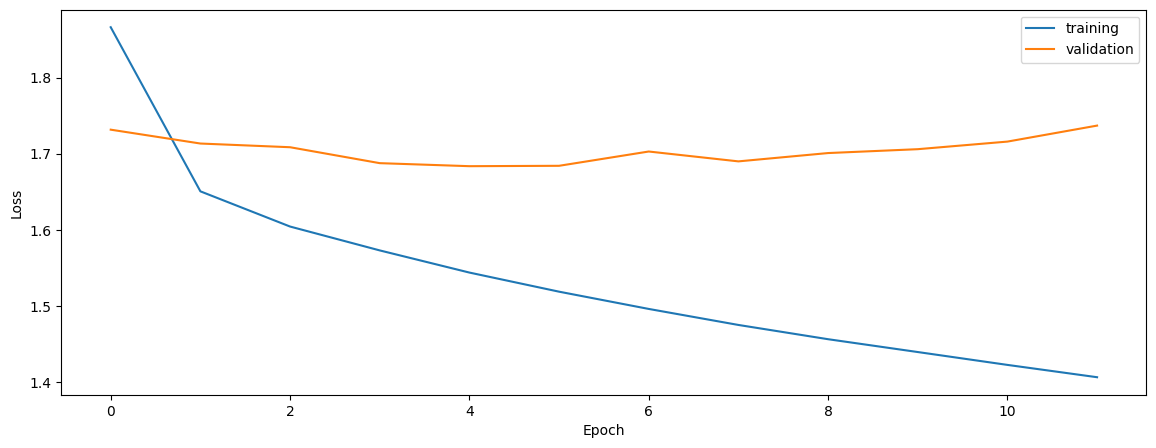

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getAccuarcy, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getAccuarcy(train[1],train_pred))
print(getAccuarcy(val[1],val_pred))
print(getAccuarcy(test[1],test_pred))

train
0.39933530835782677
0.3453070254534213
0.361778769218952


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('normalized')
print(getAccuarcy(train2[1],train_pred2))
print(getAccuarcy(val2[1],val_pred2))
print(getAccuarcy(test2[1],test_pred2))

normalized
0.4139858727511885
0.3949707648546144
0.37069209610872905


In [9]:
print('native')
print(getAccuarcy(train2[1][train2[2]],train_pred2[train2[2]]))
print(getAccuarcy(val2[1][val2[2]],val_pred2[val2[2]]))
print(getAccuarcy(test2[1][test2[2]],test_pred2[test2[2]]))

native
0.4144881264297392
0.4036560595802302
0.37189863047064425


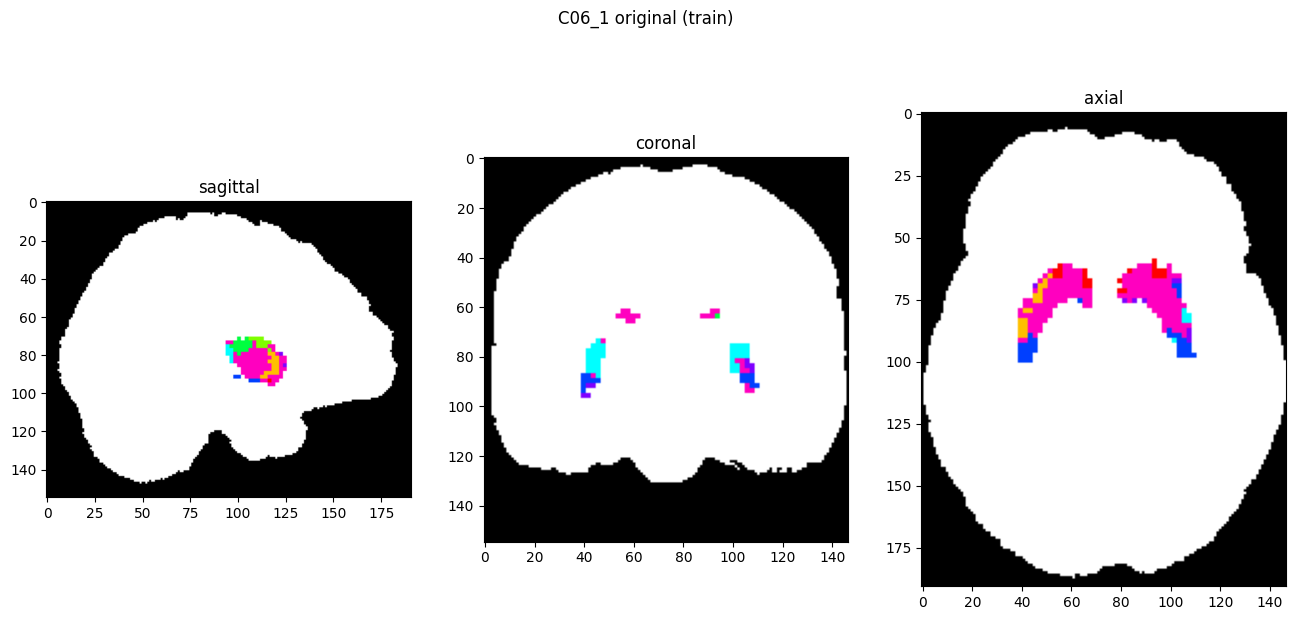

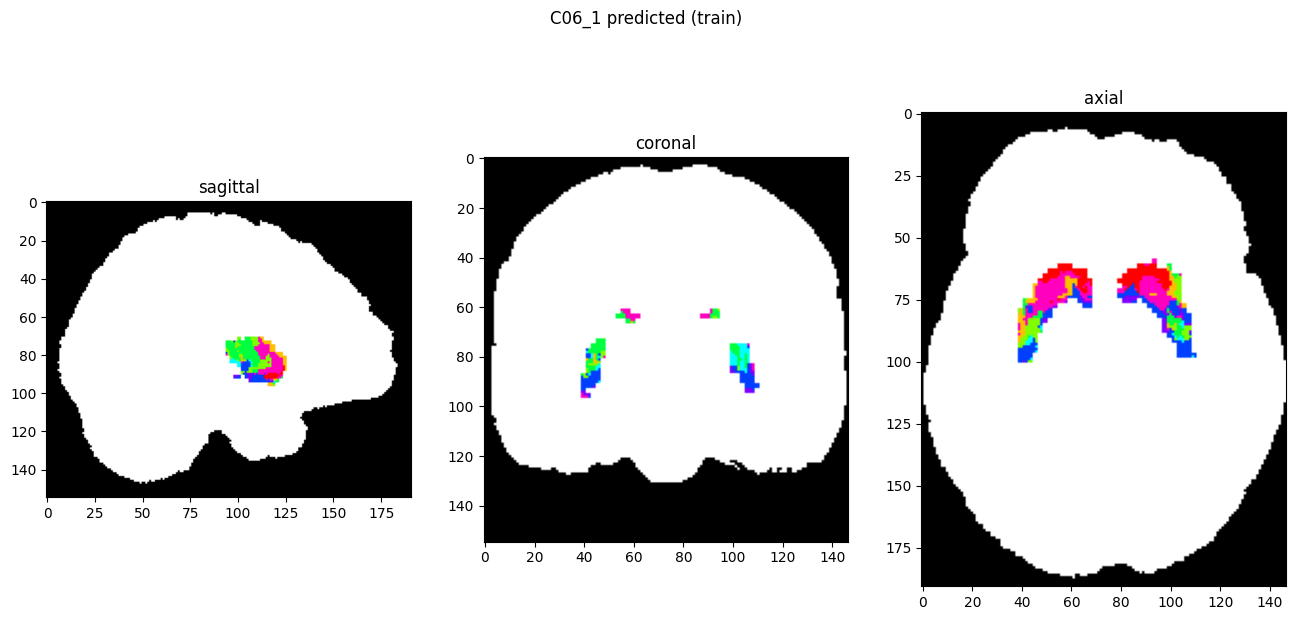

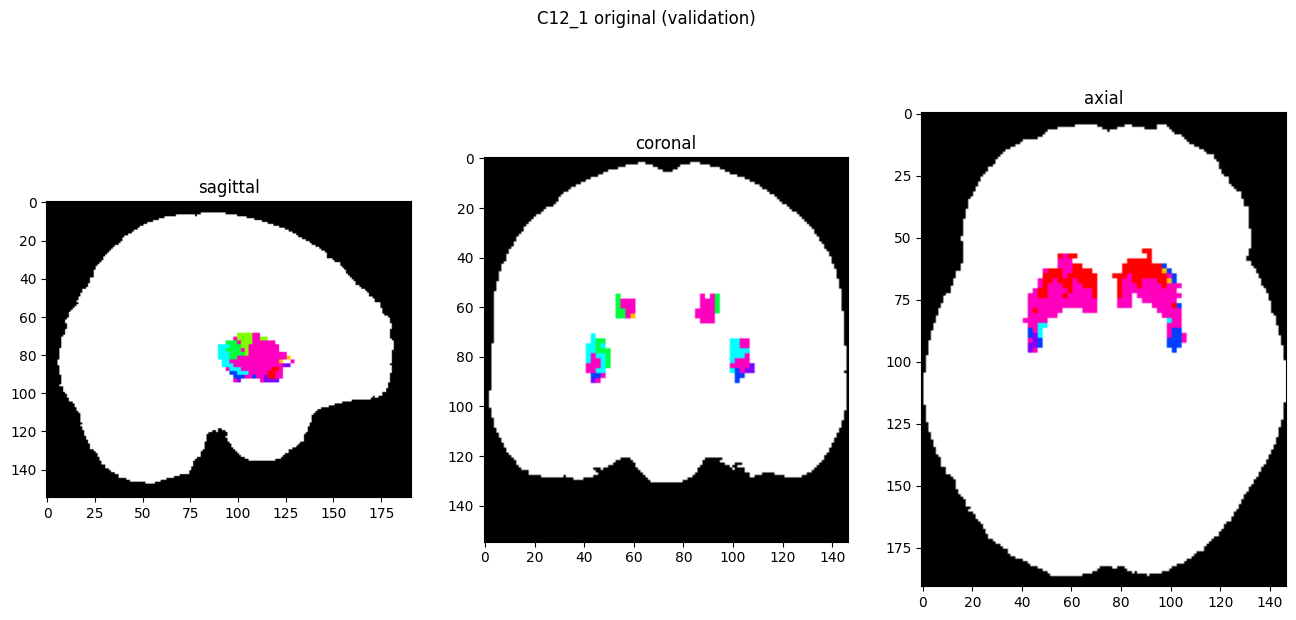

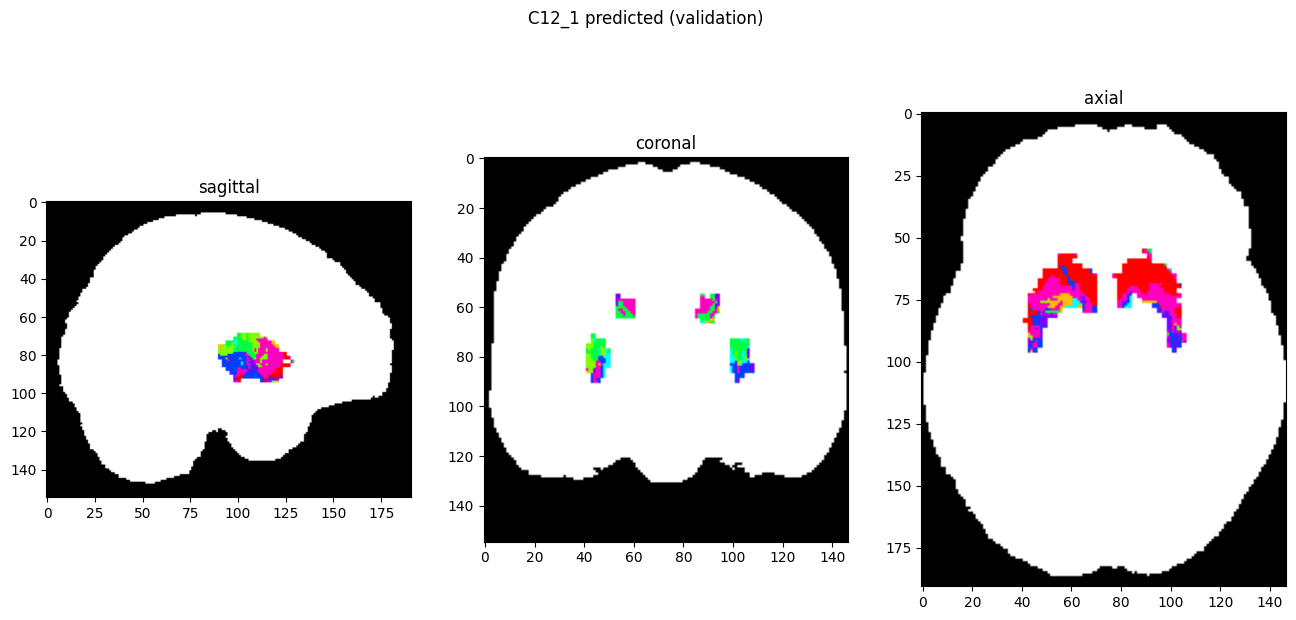

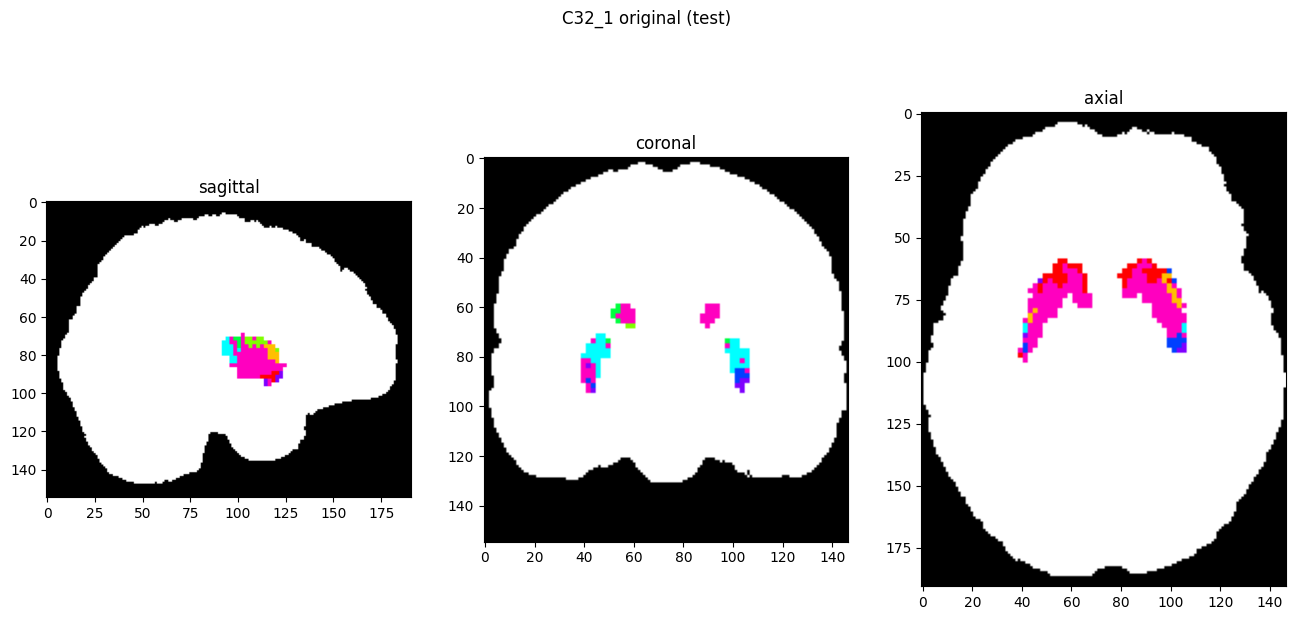

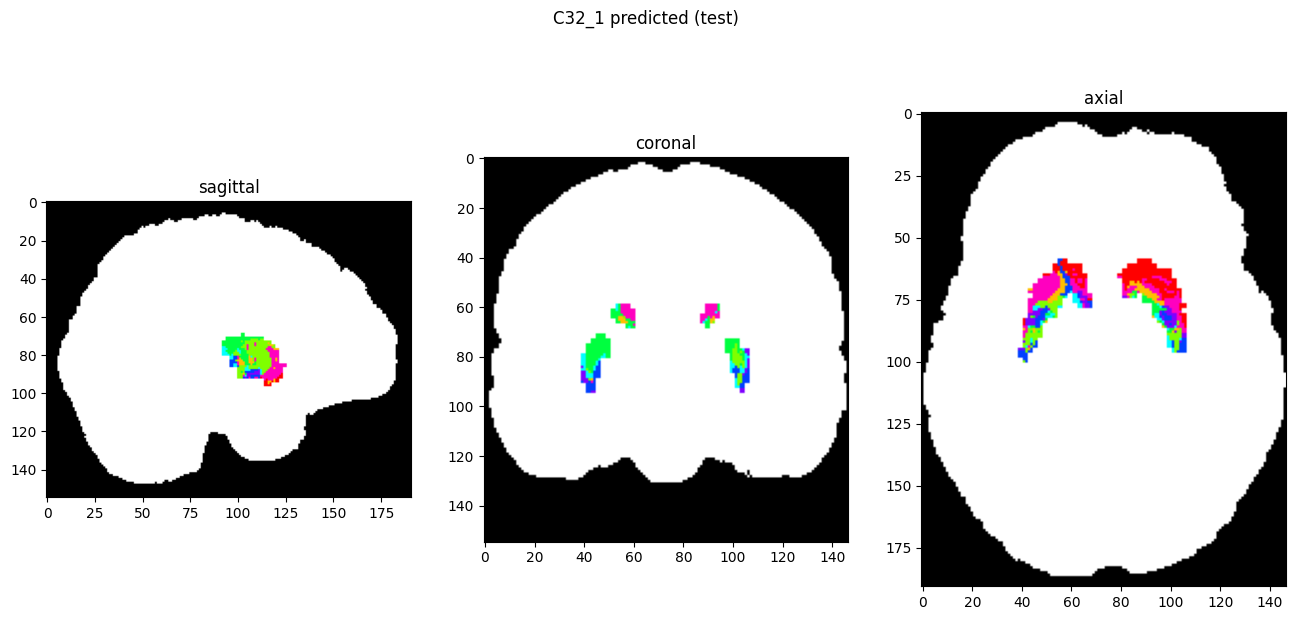

In [10]:
showResults(model, gen, threshold=0)